## Imports and Color Map

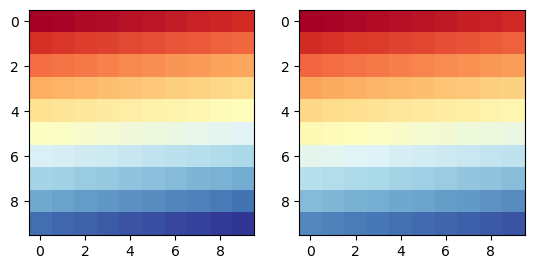

'/Users/jenburt/Dropbox/Research/Projects/RepresentativePlanets'

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
from matplotlib  import cm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from kpf_etc.etc import kpf_etc_rv, kpf_photon_noise_estimate
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.colors as colors

from uncertainties import ufloat
from uncertainties import umath

import random

hband = 1.65e-6

fduty=0.9
logCtoOsolar = -0.26

def calc_g(Mp, Rp):
    G = 6.6743E-11   # m3 kg-1 s-2
    M = Mp * 5.972e+24 # Mp in Earths to kg
    R = Rp * 6.378e+6 # Rp in Earths to m
    g = (G * M) / (R ** 2.)
    return g

def calc_Hs(T, mmw, g):
    k = 1.38064852E-23
    m = mmw * 1.66054E-27 # convert AMU to kg
    return (k*T) / (m*g)

def calc_specmod(Hs, Rp, Rstar):
    R = Rp * 6.378e+6 # Rp in Earths to m
    Rs = Rstar * 6.957e+8 # Rstar in Suns to m
    return (2.*Hs*R)/(Rs**2.)

def calc_FoM(Mp, Rp, T, mmw, Rstar, Hmag):
    g = calc_g(Mp, Rp)
    Hs = calc_Hs(T, mmw, g)
    specmod = calc_specmod(Hs, Rp, Rstar)*(1E6)
    return specmod/(10.**(0.2*Hmag))

def planck(temp,wave):
    h = 6.626070050E-34
    c = 299792458.
    kB = 1.38064852E-23
    return (((2.*h*c*c)/wave**5.)/(np.exp((h*c)/(wave*kB*temp))-1.))

def eclipsedepth(temp,startemp,wave,RpRs):
    FpFs = planck(temp,wave) / planck(startemp,wave)
    transit_depth = RpRs**2.
    eclipse_depth = FpFs * transit_depth
    return eclipse_depth

def calc_FoMe(temp,startemp,wave,RpRs,Hmag):
    FpFs = eclipsedepth(temp,startemp,wave,RpRs)
    return FpFs/(10.**(0.2*Hmag))


def truncate_colormap(cmapIn='RdYlBu', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    plt.show()

    return new_cmap

cmap_mod = truncate_colormap(minval=0, maxval=.95)  # calls function to truncate colormap

import os
os.getcwd()

## Read in POMA Rep Ranking Target Lists

In [2]:
FullList = pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')
FullList.drop(columns=['Unnamed: 0'],inplace=True)
FullList.reset_index(inplace=True,drop=True)
len(FullList)

5843

In [3]:
#Full List of viable planets
FullList = pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')
FullList.drop(columns=['Unnamed: 0'],inplace=True)
FullList.reset_index(inplace=True,drop=True)
len(FullList)

####################
#Set up list of representative known planets + candidates

Targets_Rep_All_Trans=pd.read_csv('KnownPlanetsAndCandidates_750Targets_May2025_3NightCut.csv')
Targets_Rep_All_Trans.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
Targets_Rep_All_Trans.reset_index(inplace=True,drop=True)

Targets_Rep_All_Emiss = pd.read_csv('KnownPlanetsAndCandidates_150EmissionTargets_May2025_3NightCut.csv')
Targets_Rep_All_Emiss.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
Targets_Rep_All_Emiss.reset_index(inplace=True,drop=True)

#Combine the transmission and emission lists, and remove the duplicate entries keeping the mass sigma requirements from the emission list
Combined_All = pd.concat([Targets_Rep_All_Trans, Targets_Rep_All_Emiss], axis=0)
Targets_Rep_All = Combined_All.drop_duplicates(subset=['name'], keep='last')
Targets_Rep_All.reset_index(drop=True,inplace=True)

####################
#Set up list of representative known planets

Targets_Rep_KP_Trans=pd.read_csv('KnownPlanetsOnly_750Targets_May2025_3NightCut.csv')
Targets_Rep_KP_Trans.drop(columns=['Unnamed: 0'],inplace=True)
Targets_Rep_KP_Trans.reset_index(inplace=True,drop=True)

Targets_Rep_KP_Emiss=pd.read_csv('KnownPlanetsOnly_150EmissionTargets_May2025_3NightCut.csv')
Targets_Rep_KP_Emiss.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
Targets_Rep_KP_Emiss.reset_index(inplace=True,drop=True)

#Combine the transmission and emission lists, and remove the duplicate entries keeping the mass sigma requirements from the emission list
Combined_KP = pd.concat([Targets_Rep_KP_Trans, Targets_Rep_KP_Emiss], axis=0)
Targets_Rep_KP = Combined_KP.drop_duplicates(subset=['name'], keep='last')
Targets_Rep_KP.reset_index(drop=True,inplace=True)

## Population Statistics for Full List of Viable Targets

In [4]:
print('Total number of targets: ',len(FullList))
print('Total number of KP targets: ',len(FullList[FullList['disposition']=='KP']))
print('Total number of TOI/KOI targets: ',len(FullList[FullList['disposition']!='KP']))

print('H magnitude range:')
print(np.min(FullList['hmag']),np.max(FullList['hmag']))

print('H magnitude median:')
print(np.median(FullList['hmag']))

print('V magnitude range:')
print(np.min(FullList['vmag']),np.max(FullList['vmag']))

print('V magnitude median:')
print(np.median(FullList['vmag']))

N_Fstars = len(FullList[FullList['teff_*']>5900])
N_Gstars = len(FullList[(FullList['teff_*']>5300) & (FullList['teff_*']<5900)])
N_Kstars = len(FullList[(FullList['teff_*']>3900) & (FullList['teff_*']<5300)])
N_Mstars = len(FullList[FullList['teff_*']<3900])

print('Number and percent of F stars: ',N_Fstars, N_Fstars/len(FullList))
print('Number of G stars: ',N_Gstars, N_Gstars/len(FullList))
print('Number of K stars: ',N_Kstars, N_Kstars/len(FullList))
print('Number of M stars: ',N_Mstars, N_Mstars/len(FullList))

Total number of targets:  5843
Total number of KP targets:  2276
Total number of TOI/KOI targets:  3567
H magnitude range:
3.469 15.429
H magnitude median:
11.245
V magnitude range:
5.56911 18.0
V magnitude median:
13.262
Number and percent of F stars:  1371 0.23463973985966113
Number of G stars:  2333 0.3992811911689201
Number of K stars:  1588 0.2717781961321239
Number of M stars:  532 0.09104911860345713


## Scatter Plot & Magnitude Hist for full target list

In [6]:
import matplotlib.patheffects as PathEffects
cmap = plt.cm.Blues  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,200,9)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

nplanets=len(FullList)-3

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

FullList.sort_values('FoM_trans',ascending=False,inplace=True)
FullList.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= FullList['radius_p'].values)*(FullList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= FullList['teq_p'].values) * (FullList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = FullList['FoM_trans'][idx]
                    planets.append(FullList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(FullList['FoM_trans'][idx])
                    planets.append(FullList['name'][idx][FullList['FoM_trans'][idx] == max(FullList['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(FullList['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(FullList['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(FullList['name'][idx][FullList['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, norm=norm)
# plt.colorbar(label='Number of Targets', extend='max')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
#plt.title("Population Statistics of All Viable Ariel Targets \n(Known Planets and Planet Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
plt.savefig('PaperFigures_Resubmission/Figure3_Left.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/987226767.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/987226767.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


In [7]:
vmag=FullList['vmag']
hmag=FullList['hmag']
teff=FullList['teff_*']

fig, ax = plt.subplots(figsize=(6,6))
divider = make_axes_locatable(ax)
xhax = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
yhax = divider.append_axes("right", size=1, pad=0.1, sharey=ax)

v_mean=np.mean(FullList['vmag'])
v_median=np.median(FullList['vmag'])
v_quartiles = FullList.vmag.quantile([0.25,0.75])

h_mean=np.mean(FullList['hmag'])
h_median=np.median(FullList['hmag'])
h_quartiles = FullList.hmag.quantile([0.25,0.75])


#Main Scatter Plot
plot=ax.scatter(FullList['vmag'],FullList['hmag'],alpha=.6,s=50,c=teff, cmap = cmap_mod,edgecolor='black',vmin=2500., vmax=6800.) #marker='o',color='teff',cmap=cmap_mod,zorder=2)
ax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.scatter([v_mean],[h_mean],marker='x',color='purple',zorder=3)
ax.set_xlim([4.5,19])
ax.set_ylim([3,15.5])
ax.set_xlabel("V Magnitude",fontsize=15,fontweight='bold')
ax.set_ylabel('H magnitude',fontsize=15,fontweight='bold')
ax.tick_params(axis='both',which='major',labelsize=20)
ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)

#Vmag Histogram
xhax.hist(FullList['vmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey')
xhax.set_ylabel('V mag',fontsize=14,fontweight='bold')
xhax.tick_params(axis='both',which='major',labelsize=10)
xhax.set_ylim(0,550)
xhax.set_yticks([100,300,500])
xhax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
xhax.text(5,450,'mean: '+str(np.round(v_mean,1)),fontsize=10,fontweight='bold')
xhax.text(5,375,'median: '+str(np.round(v_median,1)),fontsize=10,fontweight='bold')
xhax.text(5,300,'1st quartile: '+str(np.round(v_quartiles[0.25],1)),fontsize=10,fontweight='bold')
xhax.text(5,225,'3rd quartile: '+str(np.round(v_quartiles[0.75],1)),fontsize=10,fontweight='bold')
xhax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
xhax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

#Hmag Histogram
yhax.hist(FullList['hmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey',orientation="horizontal")
yhax.set_xlabel('H mag',fontsize=14,fontweight='bold')
yhax.tick_params(axis='both',which='major',labelsize=10)
yhax.set_xlim(0,550)
yhax.set_xticks([100,300,500])
yhax.text(450,8,'mean: '+str(np.round(h_mean,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(375,8,'median: '+str(np.round(h_median,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(300,8,'1st quartile: '+str(np.round(h_quartiles[0.25],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(225,8,'3rd quartile: '+str(np.round(h_quartiles[0.75],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
yhax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
yhax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

#cbaxes = inset_axes(ax, width="40%", height="7%", loc=2) 
#cb=fig.colorbar(plot,cax=cbaxes,ticks=[3000,4000,5000,6000], orientation='horizontal')
#cb.ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=7,width=2)
#cb.set_label(label='Stellar effective temperature [K]',weight='bold',fontsize=16)

plt.setp(ax.spines.values(), linewidth=3)
plt.setp(xhax.spines.values(), linewidth=1)
plt.setp(yhax.spines.values(), linewidth=1)
#plt.setp(cb.ax.spines.values(), linewidth=2)

#ax.scatter(vmag, hmag)
#xhax.hist(vmag)
#yhax.hist(hmag, orientation="horizontal")

##turning off duplicate ticks:
plt.setp(xhax.get_xticklabels(), visible=False)
plt.setp(yhax.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig('PaperFigures_Resubmission/Figure3_Right.pdf',format='pdf',bbox_inches=None)
plt.close()

## Scatter Plot & Magnitude Hist for KP + TOIs target list

In [8]:
vmag=Targets_Rep_All['vmag']
hmag=Targets_Rep_All['hmag']
teff=Targets_Rep_All['teff_*']

fig, ax = plt.subplots(figsize=(6,6))
divider = make_axes_locatable(ax)
xhax = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
yhax = divider.append_axes("right", size=1, pad=0.1, sharey=ax)

v_mean=np.mean(Targets_Rep_All['vmag'])
v_median=np.median(Targets_Rep_All['vmag'])
v_quartiles = Targets_Rep_All.vmag.quantile([0.25,0.75])

h_mean=np.mean(Targets_Rep_All['hmag'])
h_median=np.median(Targets_Rep_All['hmag'])
h_quartiles = Targets_Rep_All.hmag.quantile([0.25,0.75])


#Main Scatter Plot
ax.scatter(Targets_Rep_All['vmag'],Targets_Rep_All['hmag'],alpha=.6,s=50,c=teff, cmap = cmap_mod,edgecolor='black',vmin=2500., vmax=6800.) #marker='o',color='teff',cmap=cmap_mod,zorder=2)
ax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.scatter([v_mean],[h_mean],marker='x',color='purple',zorder=3)
ax.set_xlim([4.5,19])
ax.set_ylim([3,15.5])
ax.set_xlabel("V Magnitude",fontsize=15,fontweight='bold')
ax.set_ylabel('H magnitude',fontsize=15,fontweight='bold')
ax.tick_params(axis='both',which='major',labelsize=20)
ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)

#Vmag Histogram
xhax.hist(Targets_Rep_All['vmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey')
xhax.set_ylabel('V mag',fontsize=14,fontweight='bold')
xhax.tick_params(axis='both',which='major',labelsize=10)
xhax.set_ylim(0,130)
xhax.set_yticks([0,50,100])
xhax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
xhax.text(5,110,'mean: '+str(np.round(v_mean,1)),fontsize=10,fontweight='bold')
xhax.text(5,90,'median: '+str(np.round(v_median,1)),fontsize=10,fontweight='bold')
xhax.text(5,70,'1st quartile: '+str(np.round(v_quartiles[0.25],1)),fontsize=10,fontweight='bold')
xhax.text(5,50,'3rd quartile: '+str(np.round(v_quartiles[0.75],1)),fontsize=10,fontweight='bold')
xhax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
xhax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
xhax.set_title('Known Planets + Candidates',fontsize=15,fontweight='bold')


#Hmag Histogram
yhax.hist(Targets_Rep_All['hmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey',orientation="horizontal")
yhax.set_xlabel('H mag',fontsize=14,fontweight='bold')
yhax.tick_params(axis='both',which='major',labelsize=10)
yhax.set_xlim(0,130)
yhax.set_xticks([0,50,100])
yhax.text(110,8,'mean: '+str(np.round(h_mean,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(90,8,'median: '+str(np.round(h_median,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(70,8,'1st quartile: '+str(np.round(h_quartiles[0.25],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(50,8,'3rd quartile: '+str(np.round(h_quartiles[0.75],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
yhax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
yhax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

plt.setp(ax.spines.values(), linewidth=3)
plt.setp(xhax.spines.values(), linewidth=1)
plt.setp(yhax.spines.values(), linewidth=1)

##turning off duplicate ticks:
plt.setp(xhax.get_xticklabels(), visible=False)
plt.setp(yhax.get_yticklabels(), visible=False)

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure6_Right.pdf',format='pdf',bbox_inches=None)
plt.close()

## Scatter Plot & Magnitude Hist for KP Only target list

In [9]:
vmag=Targets_Rep_KP['vmag']
hmag=Targets_Rep_KP['hmag']
teff=Targets_Rep_KP['teff_*']

v_mean=np.mean(Targets_Rep_KP['vmag'])
v_median=np.median(Targets_Rep_KP['vmag'])
v_quartiles = Targets_Rep_KP.vmag.quantile([0.25,0.75])

h_mean=np.mean(Targets_Rep_KP['hmag'])
h_median=np.median(Targets_Rep_KP['hmag'])
h_quartiles = Targets_Rep_KP.hmag.quantile([0.25,0.75])

fig, ax = plt.subplots(figsize=(6,6))
divider = make_axes_locatable(ax)
xhax = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
yhax = divider.append_axes("right", size=1, pad=0.1, sharey=ax)


#Main Scatter Plot
ax.scatter(Targets_Rep_KP['vmag'],Targets_Rep_KP['hmag'],alpha=.6,s=50,c=teff, cmap = cmap_mod,edgecolor='black',vmin=2500., vmax=6800.) #marker='o',color='teff',cmap=cmap_mod,zorder=2)
ax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
ax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
ax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

ax.scatter([v_mean],[h_mean],marker='x',color='purple',zorder=3)
ax.set_xlim([4.5,19])
ax.set_ylim([3,15.5])
ax.set_xlabel("V Magnitude",fontsize=15,fontweight='bold')
ax.set_ylabel('H magnitude',fontsize=15,fontweight='bold')
ax.tick_params(axis='both',which='major',labelsize=20)
ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)

#Vmag Histogram
xhax.hist(Targets_Rep_KP['vmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey')
xhax.set_ylabel('V mag',fontsize=14,fontweight='bold')
xhax.tick_params(axis='both',which='major',labelsize=10)
xhax.set_ylim(0,130)
xhax.set_xlim([4.5,19])
xhax.set_yticks([0,50,100])
xhax.axvline(v_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
xhax.text(5,110,'mean: '+str(np.round(v_mean,1)),fontsize=10,fontweight='bold')
xhax.text(5,90,'median: '+str(np.round(v_median,1)),fontsize=10,fontweight='bold')
xhax.text(5,70,'1st quartile: '+str(np.round(v_quartiles[0.25],1)),fontsize=10,fontweight='bold')
xhax.text(5,50,'3rd quartile: '+str(np.round(v_quartiles[0.75],1)),fontsize=10,fontweight='bold')
xhax.axvline(v_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
xhax.axvline(v_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
xhax.set_title('Known Planets Only',fontsize=15,fontweight='bold')

#Hmag Histogram
yhax.hist(Targets_Rep_KP['hmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey',orientation="horizontal")
yhax.set_xlabel('H mag',fontsize=14,fontweight='bold')
yhax.tick_params(axis='both',which='major',labelsize=10)
yhax.set_xlim(0,130)
yhax.set_ylim([3,15.5])
yhax.set_xticks([0,50,100])
yhax.text(110,8,'mean: '+str(np.round(h_mean,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(90,8,'median: '+str(np.round(h_median,1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(70,8,'1st quartile: '+str(np.round(h_quartiles[0.25],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.text(50,8,'3rd quartile: '+str(np.round(h_quartiles[0.75],1)),fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.axhline(h_mean,0,20,linestyle='--',color='purple',linewidth=3,zorder=0)
yhax.axhline(h_quartiles[0.25],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)
yhax.axhline(h_quartiles[0.75],0,20,linestyle='--',color='purple',linewidth=1,alpha=.3,zorder=0)

plt.setp(ax.spines.values(), linewidth=3)
plt.setp(xhax.spines.values(), linewidth=1)
plt.setp(yhax.spines.values(), linewidth=1)

#ax.scatter(vmag, hmag)
#xhax.hist(vmag)
#yhax.hist(hmag, orientation="horizontal")

##turning off duplicate ticks:
plt.setp(xhax.get_xticklabels(), visible=False)
plt.setp(yhax.get_yticklabels(), visible=False)

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure6_Left.pdf',format='pdf',bbox_inches=None)
plt.close()

## Forbidden Island plot of Rep KP Target List

In [10]:
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=len(Targets_Rep_KP)

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Rep_KP_Targets = Targets_Rep_KP.copy()
Rep_KP_Targets.sort_values('FoM_trans',ascending=False,inplace=True)
Rep_KP_Targets.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Rep_KP_Targets['radius_p'].values)*(Rep_KP_Targets['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Rep_KP_Targets['teq_p'].values) * (Rep_KP_Targets['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Rep_KP_Targets['FoM_trans'][idx]
                    planets.append(Rep_KP_Targets['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Rep_KP_Targets['FoM_trans'][idx])
                    planets.append(Rep_KP_Targets['name'][idx][Rep_KP_Targets['FoM_trans'][idx] == max(Rep_KP_Targets['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Rep_KP_Targets['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Rep_KP_Targets['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Rep_KP_Targets['name'][idx][Rep_KP_Targets['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets Only \n Transmission [Representative]", fontsize=17,fontweight='bold')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure5_TopRight.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/2799776718.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/2799776718.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## Forbidden Island plot of FoM KP target list

In [11]:
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=750

FoM_KP_Targets = FullList[FullList['disposition']=='KP']
FoM_KP_Targets.sort_values('FoM_trans',ascending=False,inplace=True)
FoM_KP_Targets.reset_index(drop=True,inplace=True)
FoM_KP_Targets=FoM_KP_Targets[0:nplanets]

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= FoM_KP_Targets['radius_p'].values)*(FoM_KP_Targets['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= FoM_KP_Targets['teq_p'].values) * (FoM_KP_Targets['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = FoM_KP_Targets['FoM_trans'][idx]
                    planets.append(FoM_KP_Targets['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(FoM_KP_Targets['FoM_trans'][idx])
                    planets.append(FoM_KP_Targets['name'][idx][FoM_KP_Targets['FoM_trans'][idx] == max(FoM_KP_Targets['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(FoM_KP_Targets['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(FoM_KP_Targets['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(FoM_KP_Targets['name'][idx][FoM_KP_Targets['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets Only \n Transmission [Top FOM]", fontsize=17,fontweight='bold')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure4_TopLeft.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/53340618.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FoM_KP_Targets.sort_values('FoM_trans',ascending=False,inplace=True)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/53340618.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/53340618.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## Forbidden Island plot of Rep KP + TC target list

In [12]:
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)


nplanets=len(Targets_Rep_All)

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Rep_All_Targets = Targets_Rep_All.copy()
Rep_All_Targets.sort_values('FoM_trans',ascending=False,inplace=True)
Rep_All_Targets.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Rep_All_Targets['radius_p'].values)*(Rep_All_Targets['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Rep_All_Targets['teq_p'].values) * (Rep_All_Targets['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Rep_All_Targets['FoM_trans'][idx]
                    planets.append(Rep_All_Targets['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Rep_All_Targets['FoM_trans'][idx])
                    planets.append(Rep_All_Targets['name'][idx][Rep_All_Targets['FoM_trans'][idx] == max(Rep_All_Targets['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Rep_All_Targets['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Rep_All_Targets['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Rep_All_Targets['name'][idx][Rep_All_Targets['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

#plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, norm=norm)
# plt.colorbar(label='Number of Targets', extend='max')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets + Candidates \n Transmission [Representative]", fontsize=17,fontweight='bold')
#plt.title("Population Statistics of All Viable Ariel Targets \n(Known Planets and Planet Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure4_BottomRight.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4029314761.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4029314761.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## FI Plot of Rep KP + Candidates list, with 2x bins

In [ ]:
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)


nplanets=len(Targets_Rep_All)

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Rep_All_Targets = Targets_Rep_All.copy()
Rep_All_Targets.sort_values('FoM_trans',ascending=False,inplace=True)
Rep_All_Targets.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Rep_All_Targets['radius_p'].values)*(Rep_All_Targets['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Rep_All_Targets['teq_p'].values) * (Rep_All_Targets['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Rep_All_Targets['FoM_trans'][idx]
                    planets.append(Rep_All_Targets['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Rep_All_Targets['FoM_trans'][idx])
                    planets.append(Rep_All_Targets['name'][idx][Rep_All_Targets['FoM_trans'][idx] == max(Rep_All_Targets['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Rep_All_Targets['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Rep_All_Targets['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Rep_All_Targets['name'][idx][Rep_All_Targets['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

#plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, norm=norm)
# plt.colorbar(label='Number of Targets', extend='max')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets + Candidates \n Transmission [Representative]", fontsize=17,fontweight='bold')
#plt.title("Population Statistics of All Viable Ariel Targets \n(Known Planets and Planet Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
plt.show()
#plt.savefig('PaperFigures_Resubmission/Figure4_BottomRight.pdf',bbox_inches='tight')
#plt.close()

## Forbidden Island Plot of FOM KP + TC Target List

In [28]:
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=750

FoM_All_Targets = FullList.sort_values('FoM_trans',ascending=False)
FoM_All_Targets.reset_index(drop=True,inplace=True)
FoM_All_Targets=FoM_All_Targets[0:nplanets]

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0
while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= FoM_All_Targets['radius_p'].values)*(FoM_All_Targets['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= FoM_All_Targets['teq_p'].values) * (FoM_All_Targets['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = FoM_All_Targets['FoM_trans'][idx]
                    planets.append(FoM_All_Targets['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(FoM_All_Targets['FoM_trans'][idx])
                    planets.append(FoM_All_Targets['name'][idx][FoM_All_Targets['FoM_trans'][idx] == max(FoM_All_Targets['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(FoM_All_Targets['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(FoM_All_Targets['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(FoM_All_Targets['name'][idx][FoM_All_Targets['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets + Candidates \n Transmission [Top FOM]", fontsize=17,fontweight='bold')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure4_BottomLeft.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1052571523.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1052571523.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## Eclipse List & Forbidden Island Plot for Known Planets Only

In [30]:
cmap = plt.cm.Oranges  # define the colormap
cmaplist = [cmap(i) for i in range(0,150)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Viable_KP = Targets_Rep_KP_Emiss.copy()
Viable_KP.sort_values('FoM_emiss',ascending=False,inplace=True)
Viable_KP.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

nplanets=150

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Viable_KP['radius_p'].values)*(Viable_KP['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Viable_KP['teq_p'].values) * (Viable_KP['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Viable_KP['FoM_emiss'][idx]
                    planets.append(Viable_KP['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Viable_KP['FoM_emiss'][idx])
                    planets.append(Viable_KP['name'][idx][Viable_KP['FoM_emiss'][idx] == max(Viable_KP['FoM_emiss'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == 150:
                    break

                nextoneidx, = np.where(Viable_KP['FoM_emiss'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Viable_KP['FoM_emiss'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Viable_KP['name'][idx][Viable_KP['FoM_emiss'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0,vmax=10)
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets Only \n Emission", fontsize=17,fontweight='bold')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure5_Top.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3337554217.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3337554217.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## Eclipse List & Forbidden Island Plot for Known Planets + Candidates

In [31]:
cmap = plt.cm.Oranges  # define the colormap
cmaplist = [cmap(i) for i in range(0,150)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Viable_All = Targets_Rep_All_Emiss.copy()
#Viable_All = Targets_FullList_Emiss.copy()
Viable_All.sort_values('FoM_emiss',ascending=False,inplace=True)
Viable_All.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

nplanets=150

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Viable_All['radius_p'].values)*(Viable_All['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Viable_All['teq_p'].values) * (Viable_All['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Viable_All['FoM_emiss'][idx]
                    planets.append(Viable_All['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Viable_All['FoM_emiss'][idx])
                    planets.append(Viable_All['name'][idx][Viable_All['FoM_emiss'][idx] == max(Viable_All['FoM_emiss'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == 150:
                    break

                nextoneidx, = np.where(Viable_All['FoM_emiss'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Viable_All['FoM_emiss'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Viable_All['name'][idx][Viable_All['FoM_emiss'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0,vmax=10)
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
plt.title("Known Planets + Candidates \n Emission", fontsize=17,fontweight='bold')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure5_Bottom.pdf',bbox_inches='tight')
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1664338086.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1664338086.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_yticklabels(Rpvals)


## Mass Needs Histograms

In [16]:
redcol='#e41a1c'
bluecol='#377eb8'
greencol='#4daf4a'
purplecol='#984ea3'

Radii_HaveMasses_All = Targets_Rep_All['radius_p'][Targets_Rep_All['mass_sigma_needed']==0]
Radii_Need10sigMasses_All = Targets_Rep_All['radius_p'][Targets_Rep_All['mass_sigma_needed']==10]
Radii_Need5sigMasses_All = Targets_Rep_All['radius_p'][Targets_Rep_All['mass_sigma_needed']==5]
Radii_Need2sigMasses_All =   Targets_Rep_All['radius_p'][Targets_Rep_All['mass_sigma_needed']==2]

Radii_HaveMasses_KP = Targets_Rep_KP['radius_p'][Targets_Rep_KP['mass_sigma_needed']==0]
Radii_Need10sigMasses_KP = Targets_Rep_KP['radius_p'][Targets_Rep_KP['mass_sigma_needed']==10]
Radii_Need5sigMasses_KP = Targets_Rep_KP['radius_p'][Targets_Rep_KP['mass_sigma_needed']==5]
Radii_Need2sigMasses_KP =   Targets_Rep_KP['radius_p'][Targets_Rep_KP['mass_sigma_needed']==2]

ymax=100

fig = plt.figure(1,[8,14])

n_bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,
        12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23]

ax1 = fig.add_subplot(411)
ax1.hist(Radii_Need10sigMasses_KP, n_bins, edgecolor='indigo', facecolor=purplecol, linewidth=2, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax1.hist(Radii_Need10sigMasses_All, n_bins, edgecolor='black', facecolor='None', linewidth=3, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax1.text(0.5,90,'Requires a 10$\sigma$ Mass',fontsize=18,fontweight='bold',color='black',horizontalalignment='left')
txt1_a=ax1.text(22.7,52,str(len(Radii_Need10sigMasses_KP))+' Known Planets',fontsize=15,fontweight='bold',color=purplecol,horizontalalignment='right')
txt1_b=ax1.text(22.7,70,str(len(Radii_Need10sigMasses_All))+' Known Planets',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt1_c=ax1.text(22.7,62,'+ Candidates',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt1_b.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
txt1_c.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.set_ylim([0,ymax])
ax1.set_xlim([0,23])


ax2 = fig.add_subplot(412)
ax2.hist(Radii_Need5sigMasses_KP, n_bins, edgecolor='maroon', facecolor=redcol, linewidth=2, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax2.hist(Radii_Need5sigMasses_All, n_bins, edgecolor='black', facecolor='None', linewidth=3, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax2.text(0.5,90,'Requires a 5$\sigma$ Mass',fontsize=18,fontweight='bold',color='black',horizontalalignment='left')
txt2_a=ax2.text(22.7,52,str(len(Radii_Need5sigMasses_KP))+' Known Planets',fontsize=15,fontweight='bold',color=redcol,horizontalalignment='right')
txt2_b=ax2.text(22.7,70,str(len(Radii_Need5sigMasses_All))+' Known Planets',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt2_c=ax2.text(22.7,62,'+ Candidates',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt2_b.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
txt2_c.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
ax2.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.set_ylim([0,ymax])
ax2.set_xlim([0,23])

ax3 = fig.add_subplot(413)
ax3.hist(Radii_Need2sigMasses_KP, n_bins, edgecolor='midnightblue', facecolor=bluecol, linewidth=2, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax3.hist(Radii_Need2sigMasses_All, n_bins, edgecolor='black', facecolor='None', linewidth=3, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax3.text(0.5,90,'Requires a 2$\sigma$ Mass',fontsize=18,fontweight='bold',color='black',horizontalalignment='left')
ax3.text(22.7,52,str(len(Radii_Need2sigMasses_KP))+' Known Planets',fontsize=15,fontweight='bold',color=bluecol,horizontalalignment='right')
txt3_b=ax3.text(22.7,70,str(len(Radii_Need2sigMasses_All))+' Known Planets',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt3_c=ax3.text(22.7,62,'+ Candidates',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt3_b.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
txt3_c.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
ax3.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax3.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)
ax3.xaxis.set_tick_params(labelbottom=False)
ax3.set_ylim([0,ymax])
ax3.set_xlim([0,23])

ax4 = fig.add_subplot(414)
ax4.hist(Radii_HaveMasses_KP, n_bins, edgecolor='darkgreen', facecolor=greencol, linewidth=2, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax4.hist(Radii_HaveMasses_All, n_bins, edgecolor='black', facecolor='None', linewidth=3, fill=True, histtype='bar', stacked=False,rwidth=.95)
ax4.text(0.5,90,'Mass Measurement Done',fontsize=18,fontweight='bold',color='black',horizontalalignment='left')
ax4.text(22.7,52,str(len(Radii_HaveMasses_KP))+' Known Planets',fontsize=15,fontweight='bold',color=greencol,horizontalalignment='right')
txt4_b=ax4.text(22.7,70,str(len(Radii_HaveMasses_All))+' Known Planets',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt4_c=ax4.text(22.7,62,'+ Candidates',fontsize=14,fontweight='bold',color='white',horizontalalignment='right')
txt4_b.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
txt4_c.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
ax4.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax4.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)
ax4.set_ylim([0,ymax])
ax4.set_xlim([0,23])

#ax1.set_title('Representative Ranking',fontsize=30,fontweight='bold')
ax2.set_ylabel('Number of Known Planets / Candidates',fontsize=25,fontweight='bold')
ax4.set_xlabel('Planet Radius (R$_{\oplus}$)',fontsize=25,fontweight='bold')

plt.setp(ax1.spines.values(), linewidth=2)
plt.setp(ax2.spines.values(), linewidth=2)
plt.setp(ax3.spines.values(), linewidth=2)

fig.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure10.pdf') 
plt.close()

print('Rep Known + TOI list: ')
print('Number of planets that need 10-sigma masses: ',len(Radii_Need10sigMasses_All))
print('Number of planets that need 5-sigma masses: ',len(Radii_Need5sigMasses_All))
print('Number of planets that need 2-sigma masses: ',len(Radii_Need2sigMasses_All))
print('Number of planets that dont need masses: ',len(Radii_HaveMasses_All))
print(' ')
print('Rep Only Known Planets list: ')
print('Number of planets that need 10-sigma masses: ',len(Radii_Need10sigMasses_KP))
print('Number of planets that need 5-sigma masses: ',len(Radii_Need5sigMasses_KP))
print('Number of planets that need 2-sigma masses: ',len(Radii_Need2sigMasses_KP))
print('Number of planets that dont need masses: ',len(Radii_HaveMasses_KP))

Rep Known + TOI list: 
Number of planets that need 10-sigma masses:  121
Number of planets that need 5-sigma masses:  118
Number of planets that need 2-sigma masses:  313
Number of planets that dont need masses:  242
 
Rep Only Known Planets list: 
Number of planets that need 10-sigma masses:  62
Number of planets that need 5-sigma masses:  119
Number of planets that need 2-sigma masses:  210
Number of planets that dont need masses:  411


## Sky Map of Known Planets + TOIs with RV-mass needs coloring

In [32]:
redcol='#e41a1c'
bluecol='#377eb8'
greencol='#4daf4a'
purplecol='#984ea3'

eq_coords = SkyCoord(Targets_Rep_All['RA'], Targets_Rep_All['dec'], unit=u.deg)

fig = plt.figure(1,[9,5])
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1,1,1,projection='aitoff')

ax1.grid(True,linewidth=2)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_All['mass_sigma_needed']==0], eq_coords.dec.radian[Targets_Rep_All['mass_sigma_needed']==0],s=50,
    c=greencol,edgecolor='black',linewidth=0.5,zorder=1) 

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_All['mass_sigma_needed']==2], eq_coords.dec.radian[Targets_Rep_All['mass_sigma_needed']==2],s=90,
    marker='^',c=bluecol,edgecolor='navy',linewidth=0.5,zorder=2)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_All['mass_sigma_needed']==5], eq_coords.dec.radian[Targets_Rep_All['mass_sigma_needed']==5],s=80,
    marker='s',c=redcol,edgecolor='black',linewidth=1,zorder=3)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_All['mass_sigma_needed']==10], eq_coords.dec.radian[Targets_Rep_All['mass_sigma_needed']==10],s=200,
    marker='*',c=purplecol,edgecolor='black',linewidth=1,zorder=4)


ax1.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax1.spines.values(), linewidth=2)
ax1.tick_params(axis='both',which='major',labelsize=20,direction='inout',length=15,width=1)

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure7_Bottom.pdf') 
plt.close()

## Sky Map of Known Planets Only with RV-mass needs coloring

In [33]:
redcol='#e41a1c'
bluecol='#377eb8'
greencol='#4daf4a'
purplecol='#984ea3'

eq_coords = SkyCoord(Targets_Rep_KP['RA'], Targets_Rep_KP['dec'], unit=u.deg)

fig = plt.figure(1,[9,5])
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1,1,1,projection='aitoff')

ax1.grid(True,linewidth=2)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_KP['mass_sigma_needed']==0], eq_coords.dec.radian[Targets_Rep_KP['mass_sigma_needed']==0],s=50,
    c=greencol,edgecolor='black',linewidth=0.5,zorder=1) 

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_KP['mass_sigma_needed']==2], eq_coords.dec.radian[Targets_Rep_KP['mass_sigma_needed']==2],s=90,
    marker='^',c=bluecol,edgecolor='navy',linewidth=0.5,zorder=2)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_KP['mass_sigma_needed']==5], eq_coords.dec.radian[Targets_Rep_KP['mass_sigma_needed']==5],s=80,
    marker='s',c=redcol,edgecolor='black',linewidth=1,zorder=3)

ax1.scatter(eq_coords.ra.wrap_at('180d').radian[Targets_Rep_KP['mass_sigma_needed']==10], eq_coords.dec.radian[Targets_Rep_KP['mass_sigma_needed']==10],s=200,
    marker='*',c=purplecol,edgecolor='black',linewidth=1,zorder=4)


ax1.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax1.spines.values(), linewidth=2)
ax1.tick_params(axis='both',which='major',labelsize=20,direction='inout',length=15,width=1)

plt.tight_layout()
#plt.show()
plt.savefig('PaperFigures_Resubmission/Figure7_Top.pdf') 
plt.close()

## [Start Here] Calculations and Figure showing impact of TESS follow up on transit uncertainties

In [35]:
Ariel_Start = 2462622.5  #May 1, 2030, potential Ariel science start date
JWST_Start =  2460857.5  #July 1 2025, JWST Cycle 4 start date

#######################################
#   Known Planets Only Calculations   #
#######################################

T_unc_EA_KP_A  = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM2_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM3_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM4_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])

norb_EA_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM2_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM3_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM4_KP_A = np.zeros_like(Targets_Rep_KP['period_p'])

T_unc_EA_KP_J  = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM2_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM3_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])
T_unc_EM4_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])

norb_EA_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM2_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM3_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])
norb_EM4_KP_J = np.zeros_like(Targets_Rep_KP['period_p'])

for i in range(0,len(Targets_Rep_KP)):

    p_unc = Targets_Rep_KP['period_p_error'][i]
    To_unc = Targets_Rep_KP['epoch_p_err'][i]
    transit_dates = [Targets_Rep_KP['epoch_p'][i],Targets_Rep_KP['LastScheduledTransitDate'][i],Targets_Rep_KP['LastEM3TransitDate'][i],Targets_Rep_KP['LastEM4TransitDate'][i]]

    #Determine number of orbits between EA transit midpoint and Ariel / JWST
    norb_EA_KP_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:1])) / Targets_Rep_KP['period_p'][i])
    T_unc_EA_KP_A[i] = ((norb_EA_KP_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EA_KP_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:1])) / Targets_Rep_KP['period_p'][i])
    if norb_EA_KP_J[i] < 0:
        norb_EA_KP_J[i]=0
    T_unc_EA_KP_J[i] = ((norb_EA_KP_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    #Determine number of orbits between EM2 transit midpoint and Ariel / JWST
    norb_EM2_KP_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:2])) / Targets_Rep_KP['period_p'][i])
    T_unc_EM2_KP_A[i] = ((norb_EM2_KP_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM2_KP_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:2])) / Targets_Rep_KP['period_p'][i])
    if norb_EM2_KP_J[i] < 0:
        norb_EM2_KP_J[i]=0
    T_unc_EM2_KP_J[i] = ((norb_EM2_KP_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    #Determine number of orbits between EM3 transit midpoint and Ariel / JWST
    norb_EM3_KP_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:3])) / Targets_Rep_KP['period_p'][i])
    T_unc_EM3_KP_A[i] = ((norb_EM3_KP_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM3_KP_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:3])) / Targets_Rep_KP['period_p'][i])
    if norb_EM3_KP_J[i] < 0:
        norb_EM3_KP_J[i]=0
    T_unc_EM3_KP_J[i] = ((norb_EM3_KP_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    #Determine number of orbits between EM4 transit midpoint and Ariel / JWST
    norb_EM4_KP_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:4])) / Targets_Rep_KP['period_p'][i])
    T_unc_EM4_KP_A[i] = ((norb_EM4_KP_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM4_KP_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:4])) / Targets_Rep_KP['period_p'][i])
    if norb_EM4_KP_J[i] < 0:
        norb_EM4_KP_J[i]=0
    T_unc_EM4_KP_J[i] = ((norb_EM4_KP_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

#Add uncertainty values to the spreadsheet
Targets_Rep_KP['T_unc_EA_A'] = T_unc_EA_KP_A
Targets_Rep_KP['T_unc_EM2_A'] = T_unc_EM2_KP_A
Targets_Rep_KP['T_unc_EM3_A'] = T_unc_EM3_KP_A
Targets_Rep_KP['T_unc_EM3_A'] = T_unc_EM4_KP_A

Targets_Rep_KP['T_unc_EA_J'] = T_unc_EA_KP_J
Targets_Rep_KP['T_unc_EM2_J'] = T_unc_EM2_KP_J
Targets_Rep_KP['T_unc_EM3_J'] = T_unc_EM3_KP_J
Targets_Rep_KP['T_unc_EM3_J'] = T_unc_EM4_KP_J

T_unc_EA_KP_A=np.sort(T_unc_EA_KP_A)
T_unc_EM2_KP_A=np.sort(T_unc_EM2_KP_A)
T_unc_EM3_KP_A=np.sort(T_unc_EM3_KP_A)
T_unc_EM4_KP_A=np.sort(T_unc_EM4_KP_A)

T_unc_EA_KP_J=np.sort(T_unc_EA_KP_J)
T_unc_EM2_KP_J=np.sort(T_unc_EM2_KP_J)
T_unc_EM3_KP_J=np.sort(T_unc_EM3_KP_J)
T_unc_EM4_KP_J=np.sort(T_unc_EM4_KP_J)

T_unc_index_KP_A=np.zeros(len(Targets_Rep_KP))
T_unc_EA_Cumul_KP_A=np.zeros(len(Targets_Rep_KP))
T_unc_EM2_Cumul_KP_A=np.zeros(len(Targets_Rep_KP))
T_unc_EM3_Cumul_KP_A=np.zeros(len(Targets_Rep_KP))
T_unc_EM4_Cumul_KP_A=np.zeros(len(Targets_Rep_KP))

T_unc_index_KP_J=np.zeros(len(Targets_Rep_KP))
T_unc_EA_Cumul_KP_J=np.zeros(len(Targets_Rep_KP))
T_unc_EM2_Cumul_KP_J=np.zeros(len(Targets_Rep_KP))
T_unc_EM3_Cumul_KP_J=np.zeros(len(Targets_Rep_KP))
T_unc_EM4_Cumul_KP_J=np.zeros(len(Targets_Rep_KP))

for i in range(0,len(Targets_Rep_KP)):
    T_unc_index_KP_A[i]=i
    T_unc_EA_Cumul_KP_A[i]=np.nansum(T_unc_EA_KP_A[0:i+1])
    T_unc_EM2_Cumul_KP_A[i]=np.nansum(T_unc_EM2_KP_A[0:i+1])
    T_unc_EM3_Cumul_KP_A[i]=np.nansum(T_unc_EM3_KP_A[0:i+1])
    T_unc_EM4_Cumul_KP_A[i]=np.nansum(T_unc_EM4_KP_A[0:i+1])

    T_unc_index_KP_J[i]=i
    T_unc_EA_Cumul_KP_J[i]=np.nansum(T_unc_EA_KP_J[0:i+1])
    T_unc_EM2_Cumul_KP_J[i]=np.nansum(T_unc_EM2_KP_J[0:i+1])
    T_unc_EM3_Cumul_KP_J[i]=np.nansum(T_unc_EM3_KP_J[0:i+1])
    T_unc_EM4_Cumul_KP_J[i]=np.nansum(T_unc_EM4_KP_J[0:i+1])

###############################################
#   Known Planets + Candidates Calculations   #
###############################################

T_unc_EA_All_A  = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM2_All_A = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM3_All_A = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM4_All_A = np.zeros_like(Targets_Rep_All['period_p'])

T_unc_EA_All_J  = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM2_All_J = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM3_All_J = np.zeros_like(Targets_Rep_All['period_p'])
T_unc_EM4_All_J = np.zeros_like(Targets_Rep_All['period_p'])

norb_EA_All_A = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM2_All_A = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM3_All_A = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM4_All_A = np.zeros_like(Targets_Rep_All['period_p'])

norb_EA_All_J = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM2_All_J = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM3_All_J = np.zeros_like(Targets_Rep_All['period_p'])
norb_EM4_All_J = np.zeros_like(Targets_Rep_All['period_p'])

for i in range(0,len(Targets_Rep_All)):

    p_unc = Targets_Rep_All['period_p_error'][i]
    To_unc = Targets_Rep_All['epoch_p_err'][i]
    transit_dates = [Targets_Rep_All['epoch_p'][i],Targets_Rep_All['LastScheduledTransitDate'][i],Targets_Rep_All['LastEM3TransitDate'][i],Targets_Rep_All['LastEM4TransitDate'][i]]

    #Determine number of orbits between EA transit midpoint and Ariel
    norb_EA_All_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:1])) / Targets_Rep_All['period_p'][i])
    T_unc_EA_All_A[i] = ((norb_EA_All_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EA_All_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:1])) / Targets_Rep_All['period_p'][i])
    if norb_EA_All_J[i] < 0:
        norb_EA_All_J[i]=0
    T_unc_EA_All_J[i] = ((norb_EA_All_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5


    #Determine number of orbits between EM2 transit midpoint and Ariel
    norb_EM2_All_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:2])) / Targets_Rep_All['period_p'][i])
    T_unc_EM2_All_A[i] = ((norb_EM2_All_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM2_All_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:2])) / Targets_Rep_All['period_p'][i])
    if norb_EM2_All_J[i] < 0:
        norb_EM2_All_J[i]=0
    T_unc_EM2_All_J[i] = ((norb_EM2_All_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    #Determine number of orbits between EM3 transit midpoint and Ariel
    norb_EM3_All_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:3])) / Targets_Rep_All['period_p'][i])  
    T_unc_EM3_All_A[i] = ((norb_EM3_All_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM3_All_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:3])) / Targets_Rep_All['period_p'][i])
    if norb_EM3_All_J[i] < 0:
        norb_EM3_All_J[i]=0  
    T_unc_EM3_All_J[i] = ((norb_EM3_All_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    #Determine number of orbits between EM4 transit midpoint and Ariel
    norb_EM4_All_A[i] = np.ceil((Ariel_Start - np.max(transit_dates[:4])) / Targets_Rep_All['period_p'][i])
    T_unc_EM4_All_A[i] = ((norb_EM4_All_A[i]**2. * p_unc**2.) + To_unc**2.)**0.5

    norb_EM4_All_J[i] = np.ceil((JWST_Start - np.max(transit_dates[:4])) / Targets_Rep_All['period_p'][i])
    if norb_EM4_All_J[i] < 0:
        norb_EM4_All_J[i]=0   
    T_unc_EM4_All_J[i] = ((norb_EM4_All_J[i]**2. * p_unc**2.) + To_unc**2.)**0.5

#Add uncertainty values to the spreadsheet
Targets_Rep_All['T_unc_EA_A'] = T_unc_EA_All_A
Targets_Rep_All['T_unc_EM2_A'] = T_unc_EM2_All_A
Targets_Rep_All['T_unc_EM3_A'] = T_unc_EM3_All_A
Targets_Rep_All['T_unc_EM3_A'] = T_unc_EM4_All_A

T_unc_EA_All_A=np.sort(T_unc_EA_All_A)
T_unc_EM2_All_A=np.sort(T_unc_EM2_All_A)
T_unc_EM3_All_A=np.sort(T_unc_EM3_All_A)
T_unc_EM4_All_A=np.sort(T_unc_EM4_All_A)

Targets_Rep_All['T_unc_EA_J'] = T_unc_EA_All_J
Targets_Rep_All['T_unc_EM2_J'] = T_unc_EM2_All_J
Targets_Rep_All['T_unc_EM3_J'] = T_unc_EM3_All_J
Targets_Rep_All['T_unc_EM3_J'] = T_unc_EM4_All_J

T_unc_EA_All_J=np.sort(T_unc_EA_All_J)
T_unc_EM2_All_J=np.sort(T_unc_EM2_All_J)
T_unc_EM3_All_J=np.sort(T_unc_EM3_All_J)
T_unc_EM4_All_J=np.sort(T_unc_EM4_All_J)

T_unc_index_All_A=np.zeros(len(Targets_Rep_All))
T_unc_EA_Cumul_All_A=np.zeros(len(Targets_Rep_All))
T_unc_EM2_Cumul_All_A=np.zeros(len(Targets_Rep_All))
T_unc_EM3_Cumul_All_A=np.zeros(len(Targets_Rep_All))
T_unc_EM4_Cumul_All_A=np.zeros(len(Targets_Rep_All))

T_unc_index_All_J=np.zeros(len(Targets_Rep_All))
T_unc_EA_Cumul_All_J=np.zeros(len(Targets_Rep_All))
T_unc_EM2_Cumul_All_J=np.zeros(len(Targets_Rep_All))
T_unc_EM3_Cumul_All_J=np.zeros(len(Targets_Rep_All))
T_unc_EM4_Cumul_All_J=np.zeros(len(Targets_Rep_All))

for i in range(0,len(Targets_Rep_All)):
    T_unc_index_All_A[i]=i
    T_unc_EA_Cumul_All_A[i]=np.nansum(T_unc_EA_All_A[0:i+1])
    T_unc_EM2_Cumul_All_A[i]=np.nansum(T_unc_EM2_All_A[0:i+1])
    T_unc_EM3_Cumul_All_A[i]=np.nansum(T_unc_EM3_All_A[0:i+1])
    T_unc_EM4_Cumul_All_A[i]=np.nansum(T_unc_EM4_All_A[0:i+1])

    T_unc_index_All_J[i]=i
    T_unc_EA_Cumul_All_J[i]=np.nansum(T_unc_EA_All_J[0:i+1])
    T_unc_EM2_Cumul_All_J[i]=np.nansum(T_unc_EM2_All_J[0:i+1])
    T_unc_EM3_Cumul_All_J[i]=np.nansum(T_unc_EM3_All_J[0:i+1])
    T_unc_EM4_Cumul_All_J[i]=np.nansum(T_unc_EM4_All_J[0:i+1])

#Make Summary Figure
fig = plt.figure(1,[10,8])

voff=1

ax1 = fig.add_subplot(2,2,1)
ax1.plot(T_unc_index_KP_J, T_unc_EA_Cumul_KP_J+voff, linestyle='-',linewidth=2,color='black') #Exoplanet Archive epoch
ax1.plot(T_unc_index_KP_J, T_unc_EM2_Cumul_KP_J+voff, linestyle='-',linewidth=2,color='red')  #Current TESS EM epoch
#ax1.plot(T_unc_index_KP_J, T_unc_EM3_Cumul_KP_J+voff, linestyle='-',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
#ax1.plot(T_unc_index_KP_J, T_unc_EM4_Cumul_KP_J+voff, linestyle='-',linewidth=2,color='darkgreen') #Jenn's EM4 epoch

ax1.hlines(T_unc_EA_Cumul_KP_J[-1]+voff,260,len(T_unc_index_KP_J),linestyle=':',color='black')
ax1.hlines(T_unc_EM2_Cumul_KP_J[-1]+voff,260,len(T_unc_index_KP_J),linestyle=':',color='red')
#ax1.hlines(T_unc_EM3_Cumul_KP_J[-1]+voff,260,len(T_unc_index_KP_J),linestyle=':',color='goldenrod')
#ax1.hlines(T_unc_EM4_Cumul_KP_J[-1]+voff,260,len(T_unc_index_KP_J),linestyle=':',color='darkgreen')
ax1.text(250,T_unc_EA_Cumul_KP_J[-1]+voff,'EA ['+str(int(T_unc_EA_Cumul_KP_J[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax1.text(250,T_unc_EM2_Cumul_KP_J[-1]+voff,'TESS EM2 ['+str(int(T_unc_EM2_Cumul_KP_J[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
#ax1.text(250,T_unc_EM3_Cumul_KP_J[-1]+voff,'TESS EM3 ['+str(int(T_unc_EM3_Cumul_KP_J[-1]))+' d]',color='goldenrod',horizontalalignment='right',
#         verticalalignment='bottom',fontsize=8,fontweight='bold')
#ax1.text(250,T_unc_EM4_Cumul_KP_J[-1]+voff,'TESS EM4 ['+str(int(T_unc_EM4_Cumul_KP_J[-1]))+' d]',color='darkgreen',horizontalalignment='right',
#         verticalalignment='bottom',fontsize=8,fontweight='bold')

ax1.text(700,170,'As of July 1, 2025',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')

ax1.set_ylabel('Cumulative Transit \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax1.set_title('Known Planets Only',fontsize=13,fontweight='bold')

ax1.set_xlim([0,825])
ax1.set_ylim([1,190])
ax1.set_yscale('log')
ax1.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)


ax2 = fig.add_subplot(2,2,2)
ax2.plot(T_unc_index_KP_A, T_unc_EA_Cumul_KP_A+voff, linestyle='-',linewidth=2,color='black') #Exoplanet Archive epoch
ax2.plot(T_unc_index_KP_A, T_unc_EM2_Cumul_KP_A+voff, linestyle='-',linewidth=2,color='red')  #Current TESS EM epoch
ax2.plot(T_unc_index_KP_A, T_unc_EM3_Cumul_KP_A+voff, linestyle='-',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
ax2.plot(T_unc_index_KP_A, T_unc_EM4_Cumul_KP_A+voff, linestyle='-',linewidth=2,color='darkgreen') #Jenn's EM4 epoch

ax2.hlines(T_unc_EA_Cumul_KP_A[-1]+voff,260,len(T_unc_index_KP_A),linestyle=':',color='black')
ax2.hlines(T_unc_EM2_Cumul_KP_A[-1]+voff,260,len(T_unc_index_KP_A),linestyle=':',color='red')
ax2.hlines(T_unc_EM3_Cumul_KP_A[-1]+voff,260,len(T_unc_index_KP_A),linestyle=':',color='goldenrod')
ax2.hlines(T_unc_EM4_Cumul_KP_A[-1]+voff,260,len(T_unc_index_KP_A),linestyle=':',color='darkgreen')
ax2.text(250,T_unc_EA_Cumul_KP_A[-1]+voff,'EA ['+str(int(T_unc_EA_Cumul_KP_A[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(250,T_unc_EM2_Cumul_KP_A[-1]+voff,'TESS EM2 ['+str(int(T_unc_EM2_Cumul_KP_A[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(250,T_unc_EM3_Cumul_KP_A[-1]+voff,'TESS EM3 ['+str(int(T_unc_EM3_Cumul_KP_A[-1]))+' d]',color='goldenrod',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(250,T_unc_EM4_Cumul_KP_A[-1]+voff,'TESS EM4 ['+str(int(T_unc_EM4_Cumul_KP_A[-1]))+' d]',color='darkgreen',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')

ax2.text(700,170,'As of May 1, 2030',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')


#ax2.set_ylabel('Cumulative Transit \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax2.set_title('Known Planets Only',fontsize=13,fontweight='bold')

ax2.set_xlim([0,825])
ax2.set_ylim([1,190])
ax2.set_yscale('log')
ax2.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)

#JWST KP Only here
ax3 = fig.add_subplot(2,2,3)
ax3.plot(T_unc_index_All_J, T_unc_EA_Cumul_All_J+voff, linestyle='-',linewidth=2,color='black') #Exoplanet Archive epoch
ax3.plot(T_unc_index_All_J, T_unc_EM2_Cumul_All_J+voff, linestyle='-',linewidth=2,color='red')  #Current TESS EM epoch
#ax3.plot(T_unc_index_All_J, T_unc_EM3_Cumul_All_J+voff, linestyle='-',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
#ax3.plot(T_unc_index_All_J, T_unc_EM4_Cumul_All_J+voff, linestyle='-',linewidth=2,color='darkgreen') #Jenn's EM4 epoch
ax3.hlines(T_unc_EA_Cumul_All_J[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='black')
ax3.hlines(T_unc_EM2_Cumul_All_J[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='red')
#ax3.hlines(T_unc_EM3_Cumul_All_J[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='goldenrod')
#ax3.hlines(T_unc_EM4_Cumul_All_J[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='darkgreen')
ax3.text(250,T_unc_EA_Cumul_All_J[-1]+voff,'EA / TEV ['+str(int(T_unc_EA_Cumul_All_J[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax3.text(250,T_unc_EM2_Cumul_All_J[-1],'TESS EM2 ['+str(int(T_unc_EM2_Cumul_All_J[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
#ax3.text(250,T_unc_EM3_Cumul_All_J[-1],'TESS EM3 ['+str(int(T_unc_EM3_Cumul_All_J[-1]))+' d]',color='goldenrod',horizontalalignment='right',
#         verticalalignment='bottom',fontsize=8,fontweight='bold')
#ax3.text(250,T_unc_EM4_Cumul_All_J[-1],'TESS EM4 ['+str(int(T_unc_EM4_Cumul_All_J[-1]))+' d]',color='darkgreen',horizontalalignment='right',
#         verticalalignment='bottom',fontsize=8,fontweight='bold')

ax3.text(700,170,'As of July 1, 2025',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')

ax3.set_xlabel('Number of Planets',fontsize=15,fontweight='bold')
ax3.set_ylabel('Cumulative Transit \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax3.set_title('Known Planets + Candidates',fontsize=13,fontweight='bold')
ax3.set_xlim([0,825])
ax3.set_ylim([1,190])
ax3.set_yscale('log')
ax3.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax3.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)


ax4 = fig.add_subplot(2,2,4)
ax4.plot(T_unc_index_All_A, T_unc_EA_Cumul_All_A+voff, linestyle='-',linewidth=2,color='black') #Exoplanet Archive epoch
ax4.plot(T_unc_index_All_A, T_unc_EM2_Cumul_All_A+voff, linestyle='-',linewidth=2,color='red')  #Current TESS EM epoch
ax4.plot(T_unc_index_All_A, T_unc_EM3_Cumul_All_A+voff, linestyle='-',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
ax4.plot(T_unc_index_All_A, T_unc_EM4_Cumul_All_A+voff, linestyle='-',linewidth=2,color='darkgreen') #Jenn's EM4 epoch
ax4.hlines(T_unc_EA_Cumul_All_A[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='black')
ax4.hlines(T_unc_EM2_Cumul_All_A[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='red')
ax4.hlines(T_unc_EM3_Cumul_All_A[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='goldenrod')
ax4.hlines(T_unc_EM4_Cumul_All_A[-1]+voff,260,len(T_unc_index_All_A),linestyle=':',color='darkgreen')
ax4.text(250,T_unc_EA_Cumul_All_A[-1]+voff,'EA / TEV ['+str(int(T_unc_EA_Cumul_All_A[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax4.text(250,T_unc_EM2_Cumul_All_A[-1]+voff,'TESS EM2 ['+str(int(T_unc_EM2_Cumul_All_A[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax4.text(250,T_unc_EM3_Cumul_All_A[-1]+voff,'TESS EM3 ['+str(int(T_unc_EM3_Cumul_All_A[-1]))+' d]',color='goldenrod',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax4.text(250,T_unc_EM4_Cumul_All_A[-1]+voff,'TESS EM4 ['+str(int(T_unc_EM4_Cumul_All_A[-1]))+' d]',color='darkgreen',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')

ax4.text(700,170,'As of May 1, 2030',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')

ax4.set_xlabel('Number of Planets',fontsize=15,fontweight='bold')
#ax4.set_ylabel('Cumulative Transit \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax4.set_title('Known Planets + Candidates',fontsize=13,fontweight='bold')
ax4.set_xlim([0,825])
ax4.set_ylim([1,190])
ax4.set_yscale('log')
ax4.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax4.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)

plt.tight_layout()
#plt.show
plt.savefig('PaperFigures_Resubmission/Figure8.pdf',format='pdf',bbox_inches=None)
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/41819344.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Targets_Rep_KP['T_unc_EA_A'] = T_unc_EA_KP_A
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/41819344.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Targets_Rep_KP['T_unc_EM2_A'] = T_unc_EM2_KP_A
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/41819344.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## Section to determine how many targets will have stale ephemerides by JWST Cycle 4 Date [July 2025]

In [20]:
stale_All = Targets_Rep_All[Targets_Rep_All['T_unc_EA_J']*24. >= 0.5*Targets_Rep_All['duration']]
stale_All_hours = np.sum(stale_All['duration'])*2.
print('Number of stale targets from KP + TC list: ',len(stale_All))
print('Number of hours to refresh stale targets: ',stale_All_hours)

stale_KP = Targets_Rep_KP[Targets_Rep_KP['T_unc_EA_J']*24. >= 0.5*Targets_Rep_KP['duration']]
stale_KP_hours = np.sum(stale_KP['duration'])*2.
print('Number of stale targets from KP only list: ',len(stale_KP))
print('Number of hours to refresh stale KP only targets: ',stale_KP_hours)

Number of stale targets from KP + TC list:  154
Number of hours to refresh stale targets:  643.9254161378414
Number of stale targets from KP only list:  152
Number of hours to refresh stale KP only targets:  899.0423077999999


## Section to determine how many targets will have stale ephemerides by Ariel Date [May 2030]

In [21]:
stale_All = Targets_Rep_All[Targets_Rep_All['T_unc_EA_A']*24. >= 0.5*Targets_Rep_All['duration']]
stale_All_hours = np.sum(stale_All['duration'])*2.
print('Number of stale targets from KP + TC list: ',len(stale_All))
print('Number of hours to refresh stale targets: ',stale_All_hours)

stale_KP = Targets_Rep_KP[Targets_Rep_KP['T_unc_EA_A']*24. >= 0.5*Targets_Rep_KP['duration']]
stale_KP_hours = np.sum(stale_KP['duration'])*2.
print('Number of stale targets from KP only list: ',len(stale_KP))
print('Number of hours to refresh stale KP only targets: ',stale_KP_hours)

Number of stale targets from KP + TC list:  199
Number of hours to refresh stale targets:  806.322963622494
Number of stale targets from KP only list:  187
Number of hours to refresh stale KP only targets:  1105.9120786


## Calculations and Figure showing impact of TESS follow up on eclipse uncertainties

In [36]:
Ariel_Start = 2462622.5  #May 1, 2030, potential Ariel science start date
iterations = 1000000

#Note: Group A = 10% uncertainty on ecosw
A_Unc = 0.1

h_Rep_KP=np.empty(len(Targets_Rep_KP_Emiss))
h_Rep_All=np.empty(len(Targets_Rep_All_Emiss))

#Set up arrays to contain eclipse uncertainty values for both FoM target lists,
#for both ecosw uncertainty levels (20% and 10%), and for all four final transit epochs (EA, EM2, EM3, EM4)
Eo_unc_EA_KP_A = np.empty(len(Targets_Rep_KP_Emiss)) 
Eo_unc_EM2_KP_A = np.empty(len(Targets_Rep_KP_Emiss)) 
Eo_unc_EM3_KP_A = np.empty(len(Targets_Rep_KP_Emiss)) 
Eo_unc_EM4_KP_A = np.empty(len(Targets_Rep_KP_Emiss)) 

Eo_unc_EA_All_A = np.empty(len(Targets_Rep_All_Emiss)) 
Eo_unc_EM2_All_A = np.empty(len(Targets_Rep_All_Emiss)) 
Eo_unc_EM3_All_A = np.empty(len(Targets_Rep_All_Emiss)) 
Eo_unc_EM4_All_A = np.empty(len(Targets_Rep_All_Emiss)) 

###########################################
##  Section for Known Planets Only List  ##
###########################################

for i in range(0,len(Targets_Rep_KP_Emiss)):

    h_Rep_KP[i] = Targets_Rep_KP_Emiss['ecc'][i]*np.cos(np.radians(Targets_Rep_KP_Emiss['omega'][i]))

    #Determine final transit date when using either EA, TESS EM2, or suggested EM3/4
    transit_dates = [Targets_Rep_KP_Emiss['epoch_p'][i],Targets_Rep_KP_Emiss['LastScheduledTransitDate'][i],Targets_Rep_KP_Emiss['LastEM3TransitDate'][i],Targets_Rep_KP_Emiss['LastEM4TransitDate'][i]]
    norb_EA = np.ceil((Ariel_Start - np.max(transit_dates[:1])) / Targets_Rep_KP_Emiss['period_p'][i])
    norb_EM2 = np.ceil((Ariel_Start - np.max(transit_dates[:2])) / Targets_Rep_KP_Emiss['period_p'][i])
    norb_EM3 = np.ceil((Ariel_Start - np.max(transit_dates[:3])) / Targets_Rep_KP_Emiss['period_p'][i])
    norb_EM4 = np.ceil((Ariel_Start - np.max(transit_dates[:4])) / Targets_Rep_KP_Emiss['period_p'][i])

    #Calculate Eclipse Timing Uncertainty assuming ecosw uncertainty is 10% across the four final transit dates
    Eo_unc_EA_KP_A[i] = np.nanstd(np.random.normal(Targets_Rep_KP_Emiss['epoch_p'][i], Targets_Rep_KP_Emiss['epoch_p_err'][i], iterations) + \
    norb_EA * (np.random.normal(Targets_Rep_KP_Emiss['period_p'][i], Targets_Rep_KP_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_KP[i], np.abs(h_Rep_KP[i]*A_Unc), iterations)))

    Eo_unc_EM2_KP_A[i] = np.nanstd(np.random.normal(Targets_Rep_KP_Emiss['epoch_p'][i], Targets_Rep_KP_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM2 * (np.random.normal(Targets_Rep_KP_Emiss['period_p'][i], Targets_Rep_KP_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_KP[i], np.abs(h_Rep_KP[i]*A_Unc), iterations)))

    Eo_unc_EM3_KP_A[i] = np.nanstd(np.random.normal(Targets_Rep_KP_Emiss['epoch_p'][i], Targets_Rep_KP_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM3 * (np.random.normal(Targets_Rep_KP_Emiss['period_p'][i], Targets_Rep_KP_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_KP[i], np.abs(h_Rep_KP[i]*A_Unc), iterations)))

    Eo_unc_EM4_KP_A[i] = np.nanstd(np.random.normal(Targets_Rep_KP_Emiss['epoch_p'][i], Targets_Rep_KP_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM4 * (np.random.normal(Targets_Rep_KP_Emiss['period_p'][i], Targets_Rep_KP_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_KP[i], np.abs(h_Rep_KP[i]*A_Unc), iterations)))

E0_unc_index_KP_A=np.zeros(len(Targets_Rep_KP_Emiss))
Eo_unc_EA_Cumul_KP_A=np.zeros(len(Targets_Rep_KP_Emiss))
Eo_unc_EM2_Cumul_KP_A=np.zeros(len(Targets_Rep_KP_Emiss))
Eo_unc_EM3_Cumul_KP_A=np.zeros(len(Targets_Rep_KP_Emiss))
Eo_unc_EM4_Cumul_KP_A=np.zeros(len(Targets_Rep_KP_Emiss))

Eo_unc_EA_KP_A=np.sort(Eo_unc_EA_KP_A)
Eo_unc_EM2_KP_A=np.sort(Eo_unc_EM2_KP_A)
Eo_unc_EM3_KP_A=np.sort(Eo_unc_EM3_KP_A)
Eo_unc_EM4_KP_A=np.sort(Eo_unc_EM4_KP_A)

for i in range(0,len(Targets_Rep_KP_Emiss)):
    Eo_unc_EA_Cumul_KP_A[i]=np.nansum(Eo_unc_EA_KP_A[0:i+1])
    Eo_unc_EM2_Cumul_KP_A[i]=np.nansum(Eo_unc_EM2_KP_A[0:i+1])
    Eo_unc_EM3_Cumul_KP_A[i]=np.nansum(Eo_unc_EM3_KP_A[0:i+1])
    Eo_unc_EM4_Cumul_KP_A[i]=np.nansum(Eo_unc_EM4_KP_A[0:i+1])

########################################################
##  Section for Known Planets + Candidates Only List  ##
########################################################

for i in range(0,len(Targets_Rep_All_Emiss)):

    h_Rep_All[i] = Targets_Rep_All_Emiss['ecc'][i]*np.cos(np.radians(Targets_Rep_All_Emiss['omega'][i]))

    transit_dates = [Targets_Rep_All_Emiss['epoch_p'][i],Targets_Rep_All_Emiss['LastScheduledTransitDate'][i],Targets_Rep_All_Emiss['LastEM3TransitDate'][i],Targets_Rep_All_Emiss['LastEM4TransitDate'][i]]
    norb_EA = np.ceil((Ariel_Start - np.max(transit_dates[:1])) / Targets_Rep_All_Emiss['period_p'][i])
    norb_EM2 = np.ceil((Ariel_Start - np.max(transit_dates[:2])) / Targets_Rep_All_Emiss['period_p'][i])
    norb_EM3 = np.ceil((Ariel_Start - np.max(transit_dates[:3])) / Targets_Rep_All_Emiss['period_p'][i])
    norb_EM4 = np.ceil((Ariel_Start - np.max(transit_dates[:4])) / Targets_Rep_All_Emiss['period_p'][i])

    Eo_unc_EA_All_A[i] = np.nanstd(np.random.normal(Targets_Rep_All_Emiss['epoch_p'][i], Targets_Rep_All_Emiss['epoch_p_err'][i], iterations) + \
    norb_EA * (np.random.normal(Targets_Rep_All_Emiss['period_p'][i], Targets_Rep_All_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_All[i], np.abs(h_Rep_All[i]*A_Unc), iterations)))

    Eo_unc_EM2_All_A[i] = np.nanstd(np.random.normal(Targets_Rep_All_Emiss['epoch_p'][i], Targets_Rep_All_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM2 * (np.random.normal(Targets_Rep_All_Emiss['period_p'][i], Targets_Rep_All_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_All[i], np.abs(h_Rep_All[i]*A_Unc), iterations)))

    Eo_unc_EM3_All_A[i] = np.nanstd(np.random.normal(Targets_Rep_All_Emiss['epoch_p'][i], Targets_Rep_All_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM3 * (np.random.normal(Targets_Rep_All_Emiss['period_p'][i], Targets_Rep_All_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_All[i], np.abs(h_Rep_All[i]*A_Unc), iterations)))

    Eo_unc_EM4_All_A[i] = np.nanstd(np.random.normal(Targets_Rep_All_Emiss['epoch_p'][i], Targets_Rep_All_Emiss['epoch_p_err'][i], iterations) + \
    norb_EM4 * (np.random.normal(Targets_Rep_All_Emiss['period_p'][i], Targets_Rep_All_Emiss['period_p_error'][i], iterations) / 2.) * \
    (1. + (4. / np.pi) * np.random.normal(h_Rep_All[i], np.abs(h_Rep_All[i]*A_Unc), iterations)))


E0_unc_index_All=np.arange(len(Targets_Rep_All_Emiss))

Eo_unc_EA_All_A=np.sort(Eo_unc_EA_All_A)
Eo_unc_EM2_All_A=np.sort(Eo_unc_EM2_All_A)
Eo_unc_EM3_All_A=np.sort(Eo_unc_EM3_All_A)
Eo_unc_EM4_All_A=np.sort(Eo_unc_EM4_All_A)
Eo_unc_EA_Cumul_All_A=np.zeros(len(Targets_Rep_All_Emiss))
Eo_unc_EM2_Cumul_All_A=np.zeros(len(Targets_Rep_All_Emiss))
Eo_unc_EM3_Cumul_All_A=np.zeros(len(Targets_Rep_All_Emiss))
Eo_unc_EM4_Cumul_All_A=np.zeros(len(Targets_Rep_All_Emiss))

for i in range(0,len(Targets_Rep_All_Emiss)):
    Eo_unc_EA_Cumul_All_A[i]=np.nansum(Eo_unc_EA_All_A[0:i+1])
    Eo_unc_EM2_Cumul_All_A[i]=np.nansum(Eo_unc_EM2_All_A[0:i+1])
    Eo_unc_EM3_Cumul_All_A[i]=np.nansum(Eo_unc_EM3_All_A[0:i+1])
    Eo_unc_EM4_Cumul_All_A[i]=np.nansum(Eo_unc_EM4_All_A[0:i+1])

In [37]:
print('Rep Ranking, KP Only target list')
print('Total eclipse time uncertainty from EA data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EA_KP_A))
print('Total eclipse time uncertainty from EM2 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM2_KP_A))
print('Total eclipse time uncertainty from EM3 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM3_KP_A))
print('Total eclipse time uncertainty from EM4 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM4_KP_A))

print(' ')

print('Rep Ranking, KP + TC target list')
print('Total eclipse time uncertainty from EA data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EA_All_A))
print('Total eclipse time uncertainty from EM2 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM2_All_A))
print('Total eclipse time uncertainty from EM3 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM3_All_A))
print('Total eclipse time uncertainty from EM4 data at 10% ecosw uncertainties: ',np.sum(Eo_unc_EM4_All_A))

Rep Ranking, KP Only target list
Total eclipse time uncertainty from EA data at 10% ecosw uncertainties:  1173.4845865700381
Total eclipse time uncertainty from EM2 data at 10% ecosw uncertainties:  456.94742378129877
Total eclipse time uncertainty from EM3 data at 10% ecosw uncertainties:  381.2624219096808
Total eclipse time uncertainty from EM4 data at 10% ecosw uncertainties:  241.43128128295993
 
Rep Ranking, KP + TC target list
Total eclipse time uncertainty from EA data at 10% ecosw uncertainties:  550.5060697138044
Total eclipse time uncertainty from EM2 data at 10% ecosw uncertainties:  369.2210495750346
Total eclipse time uncertainty from EM3 data at 10% ecosw uncertainties:  288.9381397193677
Total eclipse time uncertainty from EM4 data at 10% ecosw uncertainties:  140.42409609970252


In [54]:
##########################
#  Make Summary Figure  ##
##########################

fig = plt.figure(1,[5,8])

ax1 = fig.add_subplot(2,1,1)
ax1.plot(E0_unc_index_All, Eo_unc_EA_Cumul_KP_A+1, linestyle='dashdot',linewidth=2,color='black') #Exoplanet Archive epoch
ax1.plot(E0_unc_index_All, Eo_unc_EM2_Cumul_KP_A+1, linestyle='dashdot',linewidth=2,color='red')  #Current TESS EM epoch
ax1.plot(E0_unc_index_All, Eo_unc_EM3_Cumul_KP_A+1, linestyle='dashdot',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
ax1.plot(E0_unc_index_All, Eo_unc_EM4_Cumul_KP_A+1, linestyle='dashdot',linewidth=2,color='darkgreen') #Jenn's EM4 epoch

ax1.hlines(Eo_unc_EA_Cumul_KP_A[-1],70,len(E0_unc_index_All),linestyle=':',color='black')
ax1.hlines(Eo_unc_EM2_Cumul_KP_A[-1],70,len(E0_unc_index_All),linestyle=':',color='red')
ax1.hlines(Eo_unc_EM3_Cumul_KP_A[-1],70,len(E0_unc_index_All),linestyle=':',color='goldenrod')
ax1.hlines(Eo_unc_EM4_Cumul_KP_A[-1],70,len(E0_unc_index_All),linestyle=':',color='darkgreen')
ax1.text(70,Eo_unc_EA_Cumul_KP_A[-1],'EA ['+str(int(Eo_unc_EA_Cumul_KP_A[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax1.text(70,Eo_unc_EM2_Cumul_KP_A[-1],'TESS EM2 ['+str(int(Eo_unc_EM2_Cumul_KP_A[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax1.text(70,Eo_unc_EM3_Cumul_KP_A[-1]-50,'TESS EM3 ['+str(int(Eo_unc_EM3_Cumul_KP_A[-1]))+' d]',color='goldenrod',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax1.text(70,Eo_unc_EM4_Cumul_KP_A[-1]-10,'TESS EM4 ['+str(int(Eo_unc_EM4_Cumul_KP_A[-1]))+' d]',color='darkgreen',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax1.text(140,5,'As of ',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')
ax1.text(150,3,'May 1, 2030',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')

ax1.set_ylabel('Total Eclipse Time \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax1.set_title('Known Planets Only',fontsize=13,fontweight='bold')

ax1.set_xlim([0,155])
ax1.set_ylim([1,1700])
ax1.set_yscale('log')
ax1.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=6,width=1)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(E0_unc_index_All, Eo_unc_EA_Cumul_All_A+1, linestyle='dashdot',linewidth=2,color='black') #Exoplanet Archive epoch
ax2.plot(E0_unc_index_All, Eo_unc_EM2_Cumul_All_A+1, linestyle='dashdot',linewidth=2,color='red')  #Current TESS EM epoch
ax2.plot(E0_unc_index_All, Eo_unc_EM3_Cumul_All_A+1, linestyle='dashdot',linewidth=2,color='goldenrod') #Jenn's EM3 epoch
ax2.plot(E0_unc_index_All, Eo_unc_EM4_Cumul_All_A+1, linestyle='dashdot',linewidth=2,color='darkgreen') #Jenn's EM4 epoch

ax2.hlines(Eo_unc_EA_Cumul_All_A[-1],70,len(E0_unc_index_All),linestyle=':',color='black')
ax2.hlines(Eo_unc_EM2_Cumul_All_A[-1],70,len(E0_unc_index_All),linestyle=':',color='red')
ax2.hlines(Eo_unc_EM3_Cumul_All_A[-1],70,len(E0_unc_index_All),linestyle=':',color='goldenrod')
ax2.hlines(Eo_unc_EM4_Cumul_All_A[-1],70,len(E0_unc_index_All),linestyle=':',color='darkgreen')
ax2.text(70,Eo_unc_EA_Cumul_All_A[-1],'EA ['+str(int(Eo_unc_EA_Cumul_All_A[-1]))+' d]',color='black',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(70,Eo_unc_EM2_Cumul_All_A[-1],'TESS EM2 ['+str(int(Eo_unc_EM2_Cumul_All_A[-1]))+' d]',color='red',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(70,Eo_unc_EM3_Cumul_All_A[-1]-30,'TESS EM3 ['+str(int(Eo_unc_EM3_Cumul_All_A[-1]))+' d]',color='goldenrod',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(70,Eo_unc_EM4_Cumul_All_A[-1],'TESS EM4 ['+str(int(Eo_unc_EM4_Cumul_All_A[-1]))+' d]',color='darkgreen',horizontalalignment='right',
         verticalalignment='bottom',fontsize=8,fontweight='bold')
ax2.text(140,5,'As of ',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')
ax2.text(150,3,'May 1, 2030',color='navy',horizontalalignment='right',verticalalignment='top',fontsize=12,fontweight='bold')


ax2.set_xlabel('Number of Planets + Candidates',fontsize=15,fontweight='bold')
ax2.set_ylabel('Total Eclipse Time \n Uncertainty [Days]',fontsize=15,fontweight='bold')
ax2.set_title('Known Planets + TCs',fontsize=13,fontweight='bold')
ax2.set_xlim([0,155])
ax2.set_ylim([1,1700])
ax2.set_yscale('log')
ax2.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=10,direction='inout',length=6,width=1)

plt.tight_layout()
#plt.show
plt.savefig('PaperFigures_Resubmission/Figure9.pdf',format='pdf',bbox_inches=None)
plt.close()

## Section to determine average transit vs eclipse depths

In [125]:
print('Summary Stats for KP + TC Representative Eclipse Targets')
print('Median eclipse depth (%) among Eclipse Targets : ',np.round(np.median(Targets_Rep_All_Emiss['eclipse_depth']*100.),2))
print('Max eclipse depth (%) among Eclipse Targets : ',np.round(np.max(Targets_Rep_All_Emiss['eclipse_depth']*100.),2))
print('Min eclipse depth (%) among Eclipse Targets : ',np.round(np.min(Targets_Rep_All_Emiss['eclipse_depth']*100.),2))
print('Number of Eclipse Targets with Eclipse depth < 0.1%: ', len(Targets_Rep_All_Emiss[Targets_Rep_All_Emiss['eclipse_depth']*100.<0.1]))

print(' ')

print('Summary Stats for KP Only Representative Eclipse Targets')
print('Median eclipse depth (%) among Eclipse Targets : ',np.round(np.median(Targets_Rep_KP_Emiss['eclipse_depth']+100.),2))
print('Max eclipse depth (%) among Eclipse Targets : ',np.round(np.max(Targets_Rep_KP_Emiss['eclipse_depth']*100.),2))
print('Min eclipse depth (%) among Eclipse Targets : ',np.round(np.min(Targets_Rep_KP_Emiss['eclipse_depth']*100.),2))
print('Number of Eclipse Targets with Eclipse depth < 0.1%: ', len(Targets_Rep_KP_Emiss[Targets_Rep_KP_Emiss['eclipse_depth']*100.<0.1]))

Summary Stats for KP + TC Representative Eclipse Targets
Median eclipse depth (%) among Eclipse Targets :  0.01
Max eclipse depth (%) among Eclipse Targets :  0.56
Min eclipse depth (%) among Eclipse Targets :  0.0
Number of Eclipse Targets with Eclipse depth < 0.1%:  142
 
Summary Stats for KP Only Representative Eclipse Targets
Median eclipse depth (%) among Eclipse Targets :  100.0
Max eclipse depth (%) among Eclipse Targets :  0.56
Min eclipse depth (%) among Eclipse Targets :  0.0
Number of Eclipse Targets with Eclipse depth < 0.1%:  143


In [134]:
Targets_Rep_All_Emiss[Targets_Rep_All_Emiss['ecc']>0.2]


#print(len(Targets_Rep_KP_Emiss[Targets_Rep_KP_Emiss['ecc']>0.2]))

,name,disposition,period_p,period_p_error,epoch_p,epoch_p_err,duration,radius_p,a/R*,ecc,ecc_err,omega,omega_err,ecosw,ecc_source,mass_p,mass_p_err,predicted_K_p,mass_sigma_needed,current_mass_sigma,logg_p,teq_p,teff_*,mass_*,radius_*,met_*,RA,dec,vmag,hmag,Met*_KIC,KPF_30min_RVSig,Nobs_30m_KPF,logCtoO,mmw,FoM_trans,FoM_emiss,eclipse_depth,LastScheduledTransitDate,LastScheduledTransitSector,LastEM3TransitDate,LastEM3TransitSector,LastEM4TransitDate,LastEM4TransitSector
10,2224.01,VPC,0.505511,0.000003,2.459989e+06,0.001269,0.648232,4.970981,2.54,0.278529,NaN,186.071339,NaN,-0.276967,SH,19.97,NaN,17.906065,10.0,0.0,0.898650,2188.221152,4932.0,0.90,1.01,0.0,61.243030,-78.374870,12.827,10.685,NaN,0.764305,0.546580,-0.26,3.149,0.683553,0.013673,0.000187,2.460933e+06,96,-1.000000e+00,-1,2.462132e+06,13
34,3505.01,VPC-+,2.915156,0.000012,2.459794e+06,0.002079,2.004000,7.457800,6.84,0.675838,NaN,251.033065,NaN,0.219663,SH,81.37,NaN,43.764066,10.0,0.0,1.156399,1681.695399,6220.0,1.20,1.34,0.0,297.043467,18.698906,11.243,10.101,NaN,0.479868,0.036069,-0.26,2.559,0.398275,0.004286,0.000045,2.460531e+06,81,2.461315e+06,14,2.462158e+06,14
50,5282.01,VPC-,1.392516,0.000006,2.459742e+06,0.001912,1.209000,9.775700,3.79,0.220455,NaN,37.572380,NaN,0.174729,SH,264.78,NaN,142.448844,10.0,0.0,1.433746,2209.081878,6082.0,1.14,1.45,0.0,269.831819,49.549809,13.632,12.239,NaN,1.702365,0.042846,-0.26,2.350,0.125810,0.008567,0.000240,2.460635e+06,85,2.461615e+06,25,2.462160e+06,14
68,6466.01,VPC,1.457190,0.000002,2.460014e+06,0.000975,0.568000,8.183890,6.65,0.291159,NaN,114.708960,NaN,-0.121707,SH,134.43,NaN,78.220084,10.0,0.0,1.293733,1566.254668,5712.0,1.02,0.82,0.0,133.233344,-31.998118,13.931,12.114,NaN,1.767950,0.153259,-0.26,2.454,0.326957,0.004369,0.000116,2.460745e+06,89,-1.000000e+00,-1,2.461991e+06,8
73,6753.01,VPC,1.016981,0.000002,2.460123e+06,0.001642,2.353000,12.198100,2.96,0.386025,NaN,91.187256,NaN,-0.007998,SH,376.28,NaN,261.124524,10.0,0.0,1.394083,2308.161782,5616.0,0.99,1.43,0.0,255.225793,-70.530095,13.907,12.240,NaN,1.701008,0.012730,-0.26,2.350,0.184688,0.019003,0.000533,2.460855e+06,93,-1.000000e+00,-1,2.462103e+06,12
79,6935.01,VPC+,1.763034,0.000199,2.460285e+06,0.002766,1.849000,9.556490,7.91,0.273372,NaN,53.882141,NaN,0.161138,SH,249.42,NaN,184.820084,10.0,0.0,1.427491,995.113345,3958.0,0.64,0.67,0.0,114.871284,9.236119,15.949,12.636,NaN,4.783611,0.200972,-0.26,2.368,0.217597,0.000640,0.000022,2.460285e+06,72,-1.000000e+00,-1,2.461966e+06,7


# RV Follow Up Stuff

## Section to determine V mag split for Known Planets + TCs Case

In [62]:
#Vmags=[5] #Put everything on KPF

#Vmags=np.arange(14.05,14.16,.05)  #For determining 6x observing time cut off
#Vmags=[14.05] #6x Vmag cut off: 14.05

Vmags=np.arange(5.5,16.5,.5) #For telescope allocation figure

NEID_Nights_Spread_All = np.full(len(Vmags),np.nan)
KPF_Nights_Spread_All = np.full(len(Vmags),np.nan)

for k in range(0,len(Vmags)):

    ############################################
    #Split planets between KPF and NEID
    ############################################

    Vmag_Split = Vmags[k]
    NEID_Targets = Targets_Rep_All[(Targets_Rep_All['vmag']<Vmag_Split) & (Targets_Rep_All['mass_sigma_needed']>0)] 
    NEID_Targets.reset_index(inplace=True,drop=True)

    KPF_Targets = Targets_Rep_All[(Targets_Rep_All['vmag']>=Vmag_Split) & (Targets_Rep_All['mass_sigma_needed']>0)]
    KPF_Targets.reset_index(inplace=True,drop=True)

    MassDone_Targets = Targets_Rep_All[Targets_Rep_All['mass_sigma_needed']==0]
    MassDone_Targets.reset_index(inplace=True,drop=True)

    ############################################
    #Calculate Obs Time needed for KPF Targets
    ############################################
    
    KPF_Final_Nobs = np.full(len(KPF_Targets),np.nan)
    KPF_Final_Texp = np.full(len(KPF_Targets),np.nan)
    KPF_Final_RV_Precision = np.full(len(KPF_Targets),np.nan)
    KPF_Final_ObsTime = np.full(len(KPF_Targets),np.nan)
    KPF_Final_TelTime = np.full(len(KPF_Targets),np.nan)
    KPF_Facility=np.full(len(KPF_Targets),'KPF')

    for i in range(0,len(KPF_Targets)):
        #print(i,KPF_Targets['name'][i])
        if KPF_Targets['Nobs_30m_KPF'][i]>=8:
            KPF_Final_Nobs[i] = np.ceil(KPF_Targets['Nobs_30m_KPF'][i])
            KPF_Final_Texp[i] = 1800.
            KPF_Final_RV_Precision[i] = KPF_Targets['KPF_30min_RVSig'][i]
        else:
            KPF_Final_Nobs[i]=8
            KPF_Final_RV_Precision[i] = np.sqrt(KPF_Final_Nobs[i]/3.0) * KPF_Targets['predicted_K_p'][i] / KPF_Targets['mass_sigma_needed'][i] 
            KPF_Final_Texp[i] = kpf_etc_rv(KPF_Targets['teff_*'][i], KPF_Targets['vmag'][i], KPF_Final_RV_Precision[i])
        KPF_Final_ObsTime[i] = KPF_Final_Texp[i] * KPF_Final_Nobs[i]
        KPF_Final_TelTime[i] = (KPF_Final_Texp[i] + 120) * KPF_Final_Nobs[i]  #open shutter + overheads from Chontos+ 2022

    KPF_Targets['Final_Nobs']=KPF_Final_Nobs
    KPF_Targets['Final_Texp']=KPF_Final_Texp
    KPF_Targets['Final_RV_Precision']=KPF_Final_RV_Precision
    KPF_Targets['Final_ObsTime']=KPF_Final_ObsTime
    KPF_Targets['Final_TelTime']=KPF_Final_TelTime
    KPF_Targets['Facility']=KPF_Facility


    ############################################
    #Calculate Obs Time needed for NEID Targets
    ############################################

    NEID_30min_Precision = np.full(len(NEID_Targets),np.nan)
    Nobs_RV_NEID_30min = np.full(len(NEID_Targets),np.nan)
    NEID_Final_Nobs = np.full(len(NEID_Targets),np.nan)
    NEID_Final_Texp = np.full(len(NEID_Targets),np.nan)
    NEID_Final_RV_Precision = np.full(len(NEID_Targets),np.nan)
    NEID_Final_ObsTime = np.full(len(NEID_Targets),np.nan)
    NEID_Final_TelTime = np.full(len(NEID_Targets),np.nan)
    NEID_Facility=np.full(len(NEID_Targets),'NEID')

    #Start with calculating the RV precision for a 30m observation, like we did for KPF
    for i in range(0,len(NEID_Targets)):
        sigma_rv_val, wvl_arr, snr_ord, dv_ord = kpf_photon_noise_estimate(NEID_Targets['teff_*'][i],NEID_Targets['vmag'][i],1800*(9.6/76),quiet=True)
        NEID_30min_Precision[i] = sigma_rv_val
        Nobs_RV_NEID_30min[i] = 3.0 * NEID_Targets['mass_sigma_needed'][i]**2 * NEID_30min_Precision[i]**2 / (NEID_Targets['predicted_K_p'][i]**2)

        if Nobs_RV_NEID_30min[i] >= 8:
            NEID_Final_Nobs[i] = np.ceil(Nobs_RV_NEID_30min[i])
            NEID_Final_Texp[i] = 1800.
            NEID_Final_RV_Precision[i] = NEID_30min_Precision[i]
        else:
            NEID_Final_Nobs[i] = 8.0
            NEID_Final_RV_Precision[i] = np.sqrt(NEID_Final_Nobs[i]/3.0) * NEID_Targets['predicted_K_p'][i] / NEID_Targets['mass_sigma_needed'][i]
            NEID_Final_Texp[i] = kpf_etc_rv(NEID_Targets['teff_*'][i], NEID_Targets['vmag'][i], NEID_Final_RV_Precision[i]) * (76/9.6)
        NEID_Final_ObsTime[i] = NEID_Final_Texp[i] * NEID_Final_Nobs[i]  #just open shutter time
        NEID_Final_TelTime[i] = (NEID_Final_Texp[i] + 180) * NEID_Final_Nobs[i]  #open shutter + overheads from Gupta+ 2021
        #print(NEID_Final_Texp[i], NEID_Final_Nobs[i], NEID_Final_RV_Precision[i], NEID_Final_ObsTime[i]/60, NEID_Final_TelTime[i]/60)

    NEID_Targets['Final_Nobs']=NEID_Final_Nobs
    NEID_Targets['Final_Texp']=NEID_Final_Texp
    NEID_Targets['Final_RV_Precision']=NEID_Final_RV_Precision
    NEID_Targets['Final_ObsTime']=NEID_Final_ObsTime
    NEID_Targets['Final_TelTime']=NEID_Final_TelTime
    NEID_Targets['Facility']=NEID_Facility

    MassDone_Targets['Final_Nobs']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_Texp']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_RV_Precision']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_ObsTime']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_TelTime']=[0]*len(MassDone_Targets)
    MassDone_Targets['Facility']=['None']*len(MassDone_Targets)

    RV_FollowUp_All= pd.concat([KPF_Targets,NEID_Targets,MassDone_Targets])
    RV_FollowUp_All['Final_TelTime'] = RV_FollowUp_All['Final_TelTime'] / (3600 * 10.) #Convert from seconds to telescope nights (10 hrs / night)

    RV_FollowUp_All.reset_index(drop=True,inplace=True)

    print('Current vmag split: ',Vmag_Split)
    print('Total number of NEID nights: ', RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='NEID'].sum())
    print('Total number of KPF nights: ',  RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='KPF'].sum())
    print(' ')
    print('Ratio of NEID telescope hours to KPF telescope hours: ')
    print(RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='NEID'].sum() / RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='KPF'].sum())
    print(' ')
    print('Number of NEID planets: ',len(NEID_Targets))
    print('Number of KPF planets: ',len(KPF_Targets))
    print(' ')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(' ')

    NEID_Nights_Spread_All[k]=RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='NEID'].sum()
    KPF_Nights_Spread_All[k]=RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='KPF'].sum()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  5.5
Total number of NEID nights:  0.0
Total number of KPF nights:  104.75755555555556
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  552
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  6.0
Total number of NEID nights:  0.0
Total number of KPF nights:  104.75755555555556
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  552
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  6.5
Total number of NEID nights:  0.0
Total number of KPF nights:  104.75755555555556
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  552
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  7.0
Total number of NEID nights:  0.18333333333333332
Total number of KPF nights:  104.66955555555555
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0017515440125856398
 
Number of NEID planets:  3
Number of KPF planets:  549
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  7.5
Total number of NEID nights:  0.3055555555555555
Total number of KPF nights:  104.6108888888889
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.002920877155341806
 
Number of NEID planets:  5
Number of KPF planets:  547
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  8.0
Total number of NEID nights:  0.36666666666666664
Total number of KPF nights:  104.58155555555555
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0035060356935682304
 
Number of NEID planets:  6
Number of KPF planets:  546
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  8.5
Total number of NEID nights:  2.0902777777777777
Total number of KPF nights:  103.93155555555555
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.020112060928987454
 
Number of NEID planets:  26
Number of KPF planets:  526
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  9.0
Total number of NEID nights:  2.6490740740740737
Total number of KPF nights:  103.66644444444444
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.025553823981044617
 
Number of NEID planets:  35
Number of KPF planets:  517
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  9.5
Total number of NEID nights:  5.5938888888888885
Total number of KPF nights:  102.86133333333333
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.05438281526801994
 
Number of NEID planets:  55
Number of KPF planets:  497
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  10.0
Total number of NEID nights:  11.96314814814815
Total number of KPF nights:  101.43488888888888
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.11793918521715448
 
Number of NEID planets:  87
Number of KPF planets:  465
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  10.5
Total number of NEID nights:  17.956759259259258
Total number of KPF nights:  100.07888888888888
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.1794260453790158
 
Number of NEID planets:  118
Number of KPF planets:  434
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  11.0
Total number of NEID nights:  26.813611111111104
Total number of KPF nights:  98.08933333333334
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.27335909216541826
 
Number of NEID planets:  162
Number of KPF planets:  390
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  11.5
Total number of NEID nights:  39.113981481481474
Total number of KPF nights:  96.18177777777777
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.4066672750825212
 
Number of NEID planets:  196
Number of KPF planets:  356
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  12.0
Total number of NEID nights:  82.46620370370371
Total number of KPF nights:  91.71066666666667
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.8991996972766204
 
Number of NEID planets:  238
Number of KPF planets:  314
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  12.5
Total number of NEID nights:  113.38574074074074
Total number of KPF nights:  88.31822222222223
 
Ratio of NEID telescope hours to KPF telescope hours: 
1.2838317833826498
 
Number of NEID planets:  271
Number of KPF planets:  281
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  13.0
Total number of NEID nights:  188.02490740740743
Total number of KPF nights:  82.36311111111111
 
Ratio of NEID telescope hours to KPF telescope hours: 
2.282877672672592
 
Number of NEID planets:  309
Number of KPF planets:  243
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  13.5
Total number of NEID nights:  328.715462962963
Total number of KPF nights:  74.02444444444444
 
Ratio of NEID telescope hours to KPF telescope hours: 
4.440633974763092
 
Number of NEID planets:  354
Number of KPF planets:  198
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  14.0
Total number of NEID nights:  375.99083333333334
Total number of KPF nights:  70.17777777777778
 
Ratio of NEID telescope hours to KPF telescope hours: 
5.357690785307157
 
Number of NEID planets:  395
Number of KPF planets:  157
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  14.5
Total number of NEID nights:  590.0454629629629
Total number of KPF nights:  61.28955555555555
 
Ratio of NEID telescope hours to KPF telescope hours: 
9.627178034079881
 
Number of NEID planets:  429
Number of KPF planets:  123
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  15.0
Total number of NEID nights:  1135.5896296296296
Total number of KPF nights:  44.70133333333334
 
Ratio of NEID telescope hours to KPF telescope hours: 
25.403931940053155
 
Number of NEID planets:  456
Number of KPF planets:  96
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  15.5
Total number of NEID nights:  1554.78
Total number of KPF nights:  31.86
 
Ratio of NEID telescope hours to KPF telescope hours: 
48.80037664783428
 
Number of NEID planets:  479
Number of KPF planets:  73
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Current vmag split:  16.0
Total number of NEID nights:  2149.8743518518518
Total number of KPF nights:  15.45511111111111
 
Ratio of NEID telescope hours to KPF telescope hours: 
139.10442548072314
 
Number of NEID planets:  504
Number of KPF planets:  48
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEID_Targets['Final_Nobs']=NEID_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEID_Targets['Final_Texp']=NEID_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/769555711.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

## Section to determine V mag split for Known Planets Only Case

In [63]:
#Split planets for NEID and KPF follow up based on host star Vmag : Vmag brighter than 12 on NEID, 
#Vmag fainter than 12 on KPF

#Vmags=[5] #For all KPF case


#Vmags=np.arange(13.85,14,.05) #For sorting out 6x V-mag cut
#Vmags=[13.95] #For all KPF case #6x Vmag cut is 13.95

Vmags=np.arange(5.5,16.5,.5) #For telescope allocation plot

NEID_Nights_Spread_KP = np.full(len(Vmags),np.nan)
KPF_Nights_Spread_KP = np.full(len(Vmags),np.nan)

for k in range(0,len(Vmags)):

    Vmag_Split = Vmags[k]
    NEID_Targets = Targets_Rep_KP[(Targets_Rep_KP['vmag']<Vmag_Split) & (Targets_Rep_KP['mass_sigma_needed']>0)] 
    NEID_Targets.reset_index(inplace=True,drop=True)

    KPF_Targets = Targets_Rep_KP[(Targets_Rep_KP['vmag']>=Vmag_Split) & (Targets_Rep_KP['mass_sigma_needed']>0)]
    KPF_Targets.reset_index(inplace=True,drop=True)

    MassDone_Targets = Targets_Rep_KP[Targets_Rep_KP['mass_sigma_needed']==0]
    MassDone_Targets.reset_index(inplace=True,drop=True)

    #Calculate Obs Time needed for KPF Targets
    KPF_Final_Nobs = np.full(len(KPF_Targets),np.nan)
    KPF_Final_Texp = np.full(len(KPF_Targets),np.nan)
    KPF_Final_RV_Precision = np.full(len(KPF_Targets),np.nan)
    KPF_Final_ObsTime = np.full(len(KPF_Targets),np.nan)
    KPF_Final_TelTime = np.full(len(KPF_Targets),np.nan)
    KPF_Facility=np.full(len(KPF_Targets),'KPF')

    for i in range(0,len(KPF_Targets)):
        #print(i,KPF_Targets['name'][i])
        if KPF_Targets['Nobs_30m_KPF'][i]>=8:
            KPF_Final_Nobs[i] = np.ceil(KPF_Targets['Nobs_30m_KPF'][i])
            KPF_Final_Texp[i] = 1800.
            KPF_Final_RV_Precision[i] = KPF_Targets['KPF_30min_RVSig'][i]
        else:
            KPF_Final_Nobs[i]=8
            #print(KPF_Targets['name'][i],KPF_Final_Nobs[i],KPF_Targets['predicted_K_p'][i],KPF_Targets['mass_sigma_needed'][i])
            KPF_Final_RV_Precision[i] = np.sqrt(KPF_Final_Nobs[i]/3.0) * KPF_Targets['predicted_K_p'][i] / KPF_Targets['mass_sigma_needed'][i] 
            #print(KPF_Targets['teff_*'][i], KPF_Targets['vmag'][i], KPF_Final_RV_Precision[i])
            KPF_Final_Texp[i] = kpf_etc_rv(KPF_Targets['teff_*'][i], KPF_Targets['vmag'][i], KPF_Final_RV_Precision[i])
        KPF_Final_ObsTime[i] = KPF_Final_Texp[i] * KPF_Final_Nobs[i]
        KPF_Final_TelTime[i] = (KPF_Final_Texp[i] + 120) * KPF_Final_Nobs[i]  #open shutter + overheads from Chontos+ 2022

    KPF_Targets['Final_Nobs']=KPF_Final_Nobs
    KPF_Targets['Final_Texp']=KPF_Final_Texp
    KPF_Targets['Final_RV_Precision']=KPF_Final_RV_Precision
    KPF_Targets['Final_ObsTime']=KPF_Final_ObsTime
    KPF_Targets['Final_TelTime']=KPF_Final_TelTime
    KPF_Targets['Facility']=KPF_Facility

    #Calculate Obs Time needed for NEID Targets

    NEID_30min_Precision = np.full(len(NEID_Targets),np.nan)
    Nobs_RV_NEID_30min = np.full(len(NEID_Targets),np.nan)
    NEID_Final_Nobs = np.full(len(NEID_Targets),np.nan)
    NEID_Final_Texp = np.full(len(NEID_Targets),np.nan)
    NEID_Final_RV_Precision = np.full(len(NEID_Targets),np.nan)
    NEID_Final_ObsTime = np.full(len(NEID_Targets),np.nan)
    NEID_Final_TelTime = np.full(len(NEID_Targets),np.nan)
    NEID_Facility=np.full(len(NEID_Targets),'NEID')

    #Start with calculating the RV precision for a 30m observation, like we did for KPF
    for i in range(0,len(NEID_Targets)):
        sigma_rv_val, wvl_arr, snr_ord, dv_ord = kpf_photon_noise_estimate(NEID_Targets['teff_*'][i],NEID_Targets['vmag'][i],1800*(9.6/76),quiet=True)
        NEID_30min_Precision[i] = sigma_rv_val
        Nobs_RV_NEID_30min[i] = 3.0 * NEID_Targets['mass_sigma_needed'][i]**2 * NEID_30min_Precision[i]**2 / (NEID_Targets['predicted_K_p'][i]**2)

        if Nobs_RV_NEID_30min[i] >= 8:
            NEID_Final_Nobs[i] = np.ceil(Nobs_RV_NEID_30min[i])
            NEID_Final_Texp[i] = 1800.
            NEID_Final_RV_Precision[i] = NEID_30min_Precision[i]
        else:
            NEID_Final_Nobs[i] = 8.0
            NEID_Final_RV_Precision[i] = np.sqrt(NEID_Final_Nobs[i]/3.0) * NEID_Targets['predicted_K_p'][i] / NEID_Targets['mass_sigma_needed'][i]
            NEID_Final_Texp[i] = kpf_etc_rv(NEID_Targets['teff_*'][i], NEID_Targets['vmag'][i], NEID_Final_RV_Precision[i]) * (76/9.6)
        NEID_Final_ObsTime[i] = NEID_Final_Texp[i] * NEID_Final_Nobs[i]  #just open shutter time
        NEID_Final_TelTime[i] = (NEID_Final_Texp[i] + 180) * NEID_Final_Nobs[i]  #open shutter + overheads from Gupta+ 2021

    NEID_Targets['Final_Nobs']=NEID_Final_Nobs
    NEID_Targets['Final_Texp']=NEID_Final_Texp
    NEID_Targets['Final_RV_Precision']=NEID_Final_RV_Precision
    NEID_Targets['Final_ObsTime']=NEID_Final_ObsTime
    NEID_Targets['Final_TelTime']=NEID_Final_TelTime
    NEID_Targets['Facility']=NEID_Facility

    MassDone_Targets['Final_Nobs']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_Texp']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_RV_Precision']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_ObsTime']=[0]*len(MassDone_Targets)
    MassDone_Targets['Final_TelTime']=[0]*len(MassDone_Targets)
    MassDone_Targets['Facility']=['None']*len(MassDone_Targets)

    RV_FollowUp_KP= pd.concat([KPF_Targets,NEID_Targets,MassDone_Targets])
    RV_FollowUp_KP.reset_index(drop=True,inplace=True)
    RV_FollowUp_KP['Final_TelTime'] = RV_FollowUp_KP['Final_TelTime'] / (3600 * 10.) #Convert from seconds to telescope nights (10 hrs / night)
    
    print('Current vmag split: ',Vmag_Split)
    print('Total number of NEID nights: ', RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='NEID'].sum())
    print('Total number of KPF nights: ',  RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='KPF'].sum())
    print(' ')
    print('Ratio of NEID telescope hours to KPF telescope hours: ')
    print(RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='NEID'].sum() / RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='KPF'].sum())
    print(' ')
    print('Number of NEID planets: ',len(NEID_Targets))
    print('Number of KPF planets: ',len(KPF_Targets))
    print(' ')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(' ')

    NEID_Nights_Spread_KP[k]=RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='NEID'].sum()
    KPF_Nights_Spread_KP[k]=RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='KPF'].sum()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  5.5
Total number of NEID nights:  0.0
Total number of KPF nights:  138.00244444444445
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  391
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  6.0
Total number of NEID nights:  0.0
Total number of KPF nights:  138.00244444444445
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  391
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  6.5
Total number of NEID nights:  0.0
Total number of KPF nights:  138.00244444444445
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0
 
Number of NEID planets:  0
Number of KPF planets:  391
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  7.0
Total number of NEID nights:  0.18333333333333332
Total number of KPF nights:  137.91444444444446
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0013293265551106563
 
Number of NEID planets:  3
Number of KPF planets:  388
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  7.5
Total number of NEID nights:  0.34824074074074074
Total number of KPF nights:  137.872
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0025258264240798764
 
Number of NEID planets:  4
Number of KPF planets:  387
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  8.0
Total number of NEID nights:  0.34824074074074074
Total number of KPF nights:  137.872
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.0025258264240798764
 
Number of NEID planets:  4
Number of KPF planets:  387
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  8.5
Total number of NEID nights:  1.8208333333333335
Total number of KPF nights:  137.36177777777777
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.013255749618202056
 
Number of NEID planets:  19
Number of KPF planets:  372
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  9.0
Total number of NEID nights:  1.9465740740740742
Total number of KPF nights:  137.30266666666668
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.014177248857080275
 
Number of NEID planets:  21
Number of KPF planets:  370
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  9.5
Total number of NEID nights:  4.744166666666666
Total number of KPF nights:  136.62422222222222
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.03472419889754379
 
Number of NEID planets:  36
Number of KPF planets:  355
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  10.0
Total number of NEID nights:  7.593333333333332
Total number of KPF nights:  135.8968888888889
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.05587569660657752
 
Number of NEID planets:  53
Number of KPF planets:  338
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  10.5
Total number of NEID nights:  11.773425925925928
Total number of KPF nights:  135.02933333333334
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.08719161707524731
 
Number of NEID planets:  72
Number of KPF planets:  319
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  11.0
Total number of NEID nights:  20.17749999999999
Total number of KPF nights:  133.61666666666667
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.1510103529998752
 
Number of NEID planets:  94
Number of KPF planets:  297
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  11.5
Total number of NEID nights:  31.682037037037034
Total number of KPF nights:  132.1877777777778
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.23967448102727035
 
Number of NEID planets:  113
Number of KPF planets:  278
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  12.0
Total number of NEID nights:  87.71518518518519
Total number of KPF nights:  127.03
 
Ratio of NEID telescope hours to KPF telescope hours: 
0.6905076374493048
 
Number of NEID planets:  147
Number of KPF planets:  244
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  12.5
Total number of NEID nights:  138.10287037037037
Total number of KPF nights:  122.73044444444444
 
Ratio of NEID telescope hours to KPF telescope hours: 
1.1252535668351178
 
Number of NEID planets:  173
Number of KPF planets:  218
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  13.0
Total number of NEID nights:  202.93666666666672
Total number of KPF nights:  117.47755555555557
 
Ratio of NEID telescope hours to KPF telescope hours: 
1.7274505390154908
 
Number of NEID planets:  206
Number of KPF planets:  185
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  13.5
Total number of NEID nights:  319.1675
Total number of KPF nights:  110.49355555555556
 
Ratio of NEID telescope hours to KPF telescope hours: 
2.8885621283091423
 
Number of NEID planets:  238
Number of KPF planets:  153
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  14.0
Total number of NEID nights:  633.6504629629629
Total number of KPF nights:  97.13755555555558
 
Ratio of NEID telescope hours to KPF telescope hours: 
6.523228419110889
 
Number of NEID planets:  274
Number of KPF planets:  117
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  14.5
Total number of NEID nights:  951.8783333333333
Total number of KPF nights:  85.88266666666667
 
Ratio of NEID telescope hours to KPF telescope hours: 
11.083474352605105
 
Number of NEID planets:  303
Number of KPF planets:  88
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  15.0
Total number of NEID nights:  1805.343611111111
Total number of KPF nights:  63.02266666666667
 
Ratio of NEID telescope hours to KPF telescope hours: 
28.64594131917264
 
Number of NEID planets:  328
Number of KPF planets:  63
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  15.5
Total number of NEID nights:  2706.188611111111
Total number of KPF nights:  40.053111111111114
 
Ratio of NEID telescope hours to KPF telescope hours: 
67.56500396695499
 
Number of NEID planets:  351
Number of KPF planets:  40
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Current vmag split:  16.0
Total number of NEID nights:  3982.2986111111113
Total number of KPF nights:  11.588888888888889
 
Ratio of NEID telescope hours to KPF telescope hours: 
343.6307526366252
 
Number of NEID planets:  375
Number of KPF planets:  16
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEID_Targets['Final_Nobs']=NEID_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEID_Targets['Final_Texp']=NEID_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/4201177815.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## Plot of telescope time requirements vs. V mag split -- Known Planets + TOIs

In [64]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:4, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)

#Vmags_Half_Mag=np.arange(5.5,16.5,.5)
#Vmags_Full_Mag=np.arange(5.5,19,1)

Vmag_split_All = 14.05
Vmags_Half_Mag_Plot=np.arange(6,18.5,.5)
Vmags_Full_Mag_Plot=np.arange(6,19,1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Bar chart of RV nights in main panel of plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

kpf_sup_nights_All = [KPF_Nights_Spread_All[-1]] *3
kpf_sup_vmags_All=[16.7,17.2,17.7]

ax_main.bar(Vmags - 0.2, NEID_Nights_Spread_All, width=0.2, label = 'NEID Nights',color='goldenrod',zorder=2)
ax_main.bar(Vmags + 0.2, KPF_Nights_Spread_All, width=0.2, label = 'KPF Nights',color='mediumblue',zorder=1)
ax_main.bar(kpf_sup_vmags_All, kpf_sup_nights_All, width=0.2, label = 'KPF Nights',color='mediumblue',zorder=1)

ax_main.axvline(Vmag_split_All,0,350,linestyle='--',color='purple',linewidth=3,zorder=0)
ax_main.axvspan(16, 18, facecolor='grey', alpha=0.5)

ax_main.text(16.5,150,'3.5m',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')
ax_main.text(17,150,'Observing',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')
ax_main.text(17.5,150,'Limit',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')

ax_main.set_xlabel("V Magnitude Split",fontsize=20,fontweight='bold')
ax_main.set_ylabel('Number of Telescope Nights',fontsize=15,fontweight='bold')
ax_main.tick_params(axis='both',which='major',labelsize=20)

ax_main.tick_params(axis='both',which='major',labelsize=20,direction='inout',length=15,width=2)
ax_main.tick_params(axis='both',which='minor',labelsize=20,direction='inout',length=10,width=1)

#ax_main.text(6.5,2700,'KPF Nights',color='mediumblue',fontweight='bold',fontsize=20)
#ax_main.text(6.5,2400,'NEID Nights',color='goldenrod',fontweight='bold',fontsize=20)

ax_main.set_xlim([5.5,18])
ax_main.set_ylim([1,8000])
ax_main.set_yscale('log')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Histogram of Stellar Vmags on top of plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax_xDist.hist(RV_FollowUp_All['vmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey')
ax_xDist.axvline(Vmag_split_All,0,350,linestyle='--',color='purple',linewidth=3)

ax_xDist.text(17.8,80,'Allocate to 10m',color='mediumblue',fontweight='bold',fontsize=12,horizontalalignment='right')
ax_xDist.text(17.8,60,'Class Telescope',color='mediumblue',fontweight='bold',fontsize=12,horizontalalignment='right')

ax_xDist.text(6.5,80,'Allocate to 3.5m',color='goldenrod',fontweight='bold',fontsize=12,horizontalalignment='left')
ax_xDist.text(6.5,60,'Class Telescope',color='goldenrod',fontweight='bold',fontsize=12,horizontalalignment='left')

ax_xDist.set_ylabel('Host stars',fontsize=14,fontweight='bold')
ax_xDist.set_title('Known Planets + Candidates',fontsize=22,fontweight='bold',va='bottom')

ax_xDist.tick_params(axis='both',which='major',labelsize=10,direction='inout',length=10,width=2)
ax_xDist.xaxis.set_tick_params(labelbottom=False)
ax_xDist.set_ylim([0,100])
ax_xDist.set_xlim([6,18])
ax_xDist.set_yticks([0,25,50,75])

plt.setp(ax_main.spines.values(), linewidth=3)
plt.setp(ax_xDist.spines.values(), linewidth=3)

plt.tight_layout()
#plt.show()

plt.savefig('PaperFigures_Resubmission/Figure11_Right.pdf',format='pdf',bbox_inches=None)
plt.close()

## Plot of telescope time requirements vs. V mag split -- Only Known Planets

In [65]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:4, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)

Vmag_split_KP = 13.95
Vmags_Half_Mag_Plot=np.arange(5.5,18.5,.5)
Vmags_Full_Mag_Plot=np.arange(6,19,1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Bar chart of RV nights in main panel of plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#kpf_sup_nights_KP = [9.6,9.6,9.6]
kpf_sup_nights_KP = [KPF_Nights_Spread_KP[-1]] *3
kpf_sup_vmags_KP=[16.7,17.2,17.7]

ax_main.bar(Vmags - 0.2, NEID_Nights_Spread_KP, width=0.2, label = 'NEID Nights',color='goldenrod',zorder=2)
ax_main.bar(Vmags + 0.2, KPF_Nights_Spread_KP, width=0.2, label = 'KPF Nights',color='mediumblue',zorder=1)
ax_main.bar(kpf_sup_vmags_KP, kpf_sup_nights_KP, width=0.2, label = 'KPF Nights',color='mediumblue',zorder=1)

ax_main.axvline(Vmag_split_KP,0,350,linestyle='--',color='purple',linewidth=3,zorder=0)
ax_main.axvspan(16, 18, facecolor='grey', alpha=0.5)

ax_main.set_xlabel("V Magnitude Split",fontsize=20,fontweight='bold')
ax_main.set_ylabel('Number of Telescope Nights',fontsize=15,fontweight='bold')
ax_main.tick_params(axis='both',which='major',labelsize=20)

ax_main.tick_params(axis='both',which='major',labelsize=20,direction='inout',length=15,width=2)
ax_main.tick_params(axis='both',which='minor',labelsize=20,direction='inout',length=10,width=1)

ax_main.text(16.5,150,'3.5m',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')
ax_main.text(17,150,'Observing',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')
ax_main.text(17.5,150,'Limit',color='r',fontsize=16.5,fontweight='bold',rotation=90, rotation_mode='anchor')

ax_main.set_xlim([6,18])
ax_main.set_ylim([1,8000])
ax_main.set_yscale('log')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Histogram of Stellar Vmags on top of plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax_xDist.hist(RV_FollowUp_KP['vmag'],bins=40,align='mid',color='dimgrey',histtype='bar', ec='grey')
ax_xDist.axvline(Vmag_split_KP,0,350,linestyle='--',color='purple',linewidth=3)

ax_xDist.text(17.8,80,'Allocate to 10m',color='mediumblue',fontweight='bold',fontsize=12,horizontalalignment='right')
ax_xDist.text(17.8,60,'Class Telescope',color='mediumblue',fontweight='bold',fontsize=12,horizontalalignment='right')

ax_xDist.text(6.5,80,'Allocate to 3.5m',color='goldenrod',fontweight='bold',fontsize=12,horizontalalignment='left')
ax_xDist.text(6.5,60,'Class Telescope',color='goldenrod',fontweight='bold',fontsize=12,horizontalalignment='left')

ax_xDist.set_ylabel('Host stars',fontsize=14,fontweight='bold')
ax_xDist.set_title('Known Planets Only',fontsize=22,fontweight='bold',va='bottom')

ax_xDist.tick_params(axis='both',which='major',labelsize=10,direction='inout',length=10,width=2)
ax_xDist.xaxis.set_tick_params(labelbottom=False)
ax_xDist.set_ylim([0,100])
ax_xDist.set_xlim([6,18])
ax_xDist.set_yticks([0,25,50,75])

plt.setp(ax_main.spines.values(), linewidth=3)
plt.setp(ax_xDist.spines.values(), linewidth=3)

plt.tight_layout()
#plt.show()

plt.savefig('PaperFigures_Resubmission/Figure11_Left.pdf',format='pdf',bbox_inches=None)
plt.close()

## Make version of RV follow up array using only Keck for the RV prioritization figure

In [76]:
KPF_Nights_Spread_All = np.full(len(Vmags),np.nan)

KPF_Targets = Targets_Rep_All[Targets_Rep_All['mass_sigma_needed']>0]
KPF_Targets.reset_index(inplace=True,drop=True)

MassDone_Targets = Targets_Rep_All[Targets_Rep_All['mass_sigma_needed']==0]
MassDone_Targets.reset_index(inplace=True,drop=True)

############################################
#Calculate Obs Time needed for KPF Targets
############################################
    
KPF_Final_Nobs = np.full(len(KPF_Targets),np.nan)
KPF_Final_Texp = np.full(len(KPF_Targets),np.nan)
KPF_Final_RV_Precision = np.full(len(KPF_Targets),np.nan)
KPF_Final_ObsTime = np.full(len(KPF_Targets),np.nan)
KPF_Final_TelTime = np.full(len(KPF_Targets),np.nan)
KPF_Facility=np.full(len(KPF_Targets),'KPF')

for i in range(0,len(KPF_Targets)):
    #print(i,KPF_Targets['name'][i])
    if KPF_Targets['Nobs_30m_KPF'][i]>=8:
        KPF_Final_Nobs[i] = np.ceil(KPF_Targets['Nobs_30m_KPF'][i])
        KPF_Final_Texp[i] = 1800.
        KPF_Final_RV_Precision[i] = KPF_Targets['KPF_30min_RVSig'][i]
    else:
        KPF_Final_Nobs[i]=8
        KPF_Final_RV_Precision[i] = np.sqrt(KPF_Final_Nobs[i]/3.0) * KPF_Targets['predicted_K_p'][i] / KPF_Targets['mass_sigma_needed'][i] 
        KPF_Final_Texp[i] = kpf_etc_rv(KPF_Targets['teff_*'][i], KPF_Targets['vmag'][i], KPF_Final_RV_Precision[i])
    KPF_Final_ObsTime[i] = KPF_Final_Texp[i] * KPF_Final_Nobs[i]
    KPF_Final_TelTime[i] = (KPF_Final_Texp[i] + 120) * KPF_Final_Nobs[i]  #open shutter + overheads from Chontos+ 2022

KPF_Targets['Final_Nobs']=KPF_Final_Nobs
KPF_Targets['Final_Texp']=KPF_Final_Texp
KPF_Targets['Final_RV_Precision']=KPF_Final_RV_Precision
KPF_Targets['Final_ObsTime']=KPF_Final_ObsTime
KPF_Targets['Final_TelTime']=KPF_Final_TelTime
KPF_Targets['Facility']=KPF_Facility

MassDone_Targets['Final_Nobs']=[0]*len(MassDone_Targets)
MassDone_Targets['Final_Texp']=[0]*len(MassDone_Targets)
MassDone_Targets['Final_RV_Precision']=[0]*len(MassDone_Targets)
MassDone_Targets['Final_ObsTime']=[0]*len(MassDone_Targets)
MassDone_Targets['Final_TelTime']=[0]*len(MassDone_Targets)
MassDone_Targets['Facility']=['None']*len(MassDone_Targets)

RV_FollowUp_All= pd.concat([KPF_Targets,MassDone_Targets])
RV_FollowUp_All['Final_TelTime'] = RV_FollowUp_All['Final_TelTime'] / (3600 * 10.) #Convert from seconds to telescope nights (10 hrs / night)

RV_FollowUp_All.reset_index(drop=True,inplace=True)

#Print out some summary numbers for putting everything on KPF
print('Total number of KPF nights: ',  RV_FollowUp_All['Final_TelTime'][RV_FollowUp_All['Facility']=='KPF'].sum())
print('Total number of KPF planets: ',  len(RV_FollowUp_All))
print(' ')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(' ')

Total number of KPF nights:  104.75755555555556
Total number of KPF planets:  794
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/2498317047.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Nobs']=KPF_Final_Nobs
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/2498317047.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets['Final_Texp']=KPF_Final_Texp
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/2498317047.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [66]:
KPF_Nights_Spread_KP = np.full(len(Vmags),np.nan)

KPF_Targets_KP = Targets_Rep_KP[Targets_Rep_KP['mass_sigma_needed']>0]
KPF_Targets_KP.reset_index(inplace=True,drop=True)

MassDone_Targets_KP = Targets_Rep_KP[Targets_Rep_KP['mass_sigma_needed']==0]
MassDone_Targets_KP.reset_index(inplace=True,drop=True)

############################################
#Calculate Obs Time needed for KPF Targets
############################################
    
KPF_Final_Nobs_KP = np.full(len(KPF_Targets_KP),np.nan)
KPF_Final_Texp_KP = np.full(len(KPF_Targets_KP),np.nan)
KPF_Final_RV_Precision_KP = np.full(len(KPF_Targets_KP),np.nan)
KPF_Final_ObsTime_KP = np.full(len(KPF_Targets_KP),np.nan)
KPF_Final_TelTime_KP = np.full(len(KPF_Targets_KP),np.nan)
KPF_Facility_KP=np.full(len(KPF_Targets_KP),'KPF')

for i in range(0,len(KPF_Targets_KP)):
    #print(i,KPF_Targets['name'][i])
    if KPF_Targets_KP['Nobs_30m_KPF'][i]>=8:
        KPF_Final_Nobs_KP[i] = np.ceil(KPF_Targets_KP['Nobs_30m_KPF'][i])
        KPF_Final_Texp_KP[i] = 1800.
        KPF_Final_RV_Precision_KP[i] = KPF_Targets_KP['KPF_30min_RVSig'][i]
    else:
        KPF_Final_Nobs_KP[i]=8
        KPF_Final_RV_Precision_KP[i] = np.sqrt(KPF_Final_Nobs_KP[i]/3.0) * KPF_Targets_KP['predicted_K_p'][i] / KPF_Targets_KP['mass_sigma_needed'][i] 
        KPF_Final_Texp_KP[i] = kpf_etc_rv(KPF_Targets_KP['teff_*'][i], KPF_Targets_KP['vmag'][i], KPF_Final_RV_Precision_KP[i])
    KPF_Final_ObsTime_KP[i] = KPF_Final_Texp_KP[i] * KPF_Final_Nobs_KP[i]
    KPF_Final_TelTime_KP[i] = (KPF_Final_Texp_KP[i] + 120) * KPF_Final_Nobs_KP[i]  #open shutter + overheads from Chontos+ 2022

KPF_Targets_KP['Final_Nobs']=KPF_Final_Nobs_KP
KPF_Targets_KP['Final_Texp']=KPF_Final_Texp_KP
KPF_Targets_KP['Final_RV_Precision']=KPF_Final_RV_Precision_KP
KPF_Targets_KP['Final_ObsTime']=KPF_Final_ObsTime_KP
KPF_Targets_KP['Final_TelTime']=KPF_Final_TelTime_KP
KPF_Targets_KP['Facility']=KPF_Facility_KP

MassDone_Targets_KP['Final_Nobs']=[0]*len(MassDone_Targets_KP)
MassDone_Targets_KP['Final_Texp']=[0]*len(MassDone_Targets_KP)
MassDone_Targets_KP['Final_RV_Precision']=[0]*len(MassDone_Targets_KP)
MassDone_Targets_KP['Final_ObsTime']=[0]*len(MassDone_Targets_KP)
MassDone_Targets_KP['Final_TelTime']=[0]*len(MassDone_Targets_KP)
MassDone_Targets_KP['Facility']=['None']*len(MassDone_Targets_KP)

RV_FollowUp_KP= pd.concat([KPF_Targets_KP,MassDone_Targets_KP])
RV_FollowUp_KP['Final_TelTime'] = RV_FollowUp_KP['Final_TelTime'] / (3600 * 10.) #Convert from seconds to telescope nights (10 hrs / night)

RV_FollowUp_KP.reset_index(drop=True,inplace=True)

#Print out some summary numbers for putting everything on KPF
print('Total number of KPF nights: ',  RV_FollowUp_KP['Final_TelTime'][RV_FollowUp_KP['Facility']=='KPF'].sum())
print('Total number of KPF planets: ',  len(RV_FollowUp_KP))
print(' ')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(' ')

Total number of KPF nights:  138.00244444444445
Total number of KPF planets:  802
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1954052772.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets_KP['Final_Nobs']=KPF_Final_Nobs_KP
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1954052772.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPF_Targets_KP['Final_Texp']=KPF_Final_Texp_KP
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1954052772.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

## Summary Figure of RV Targets

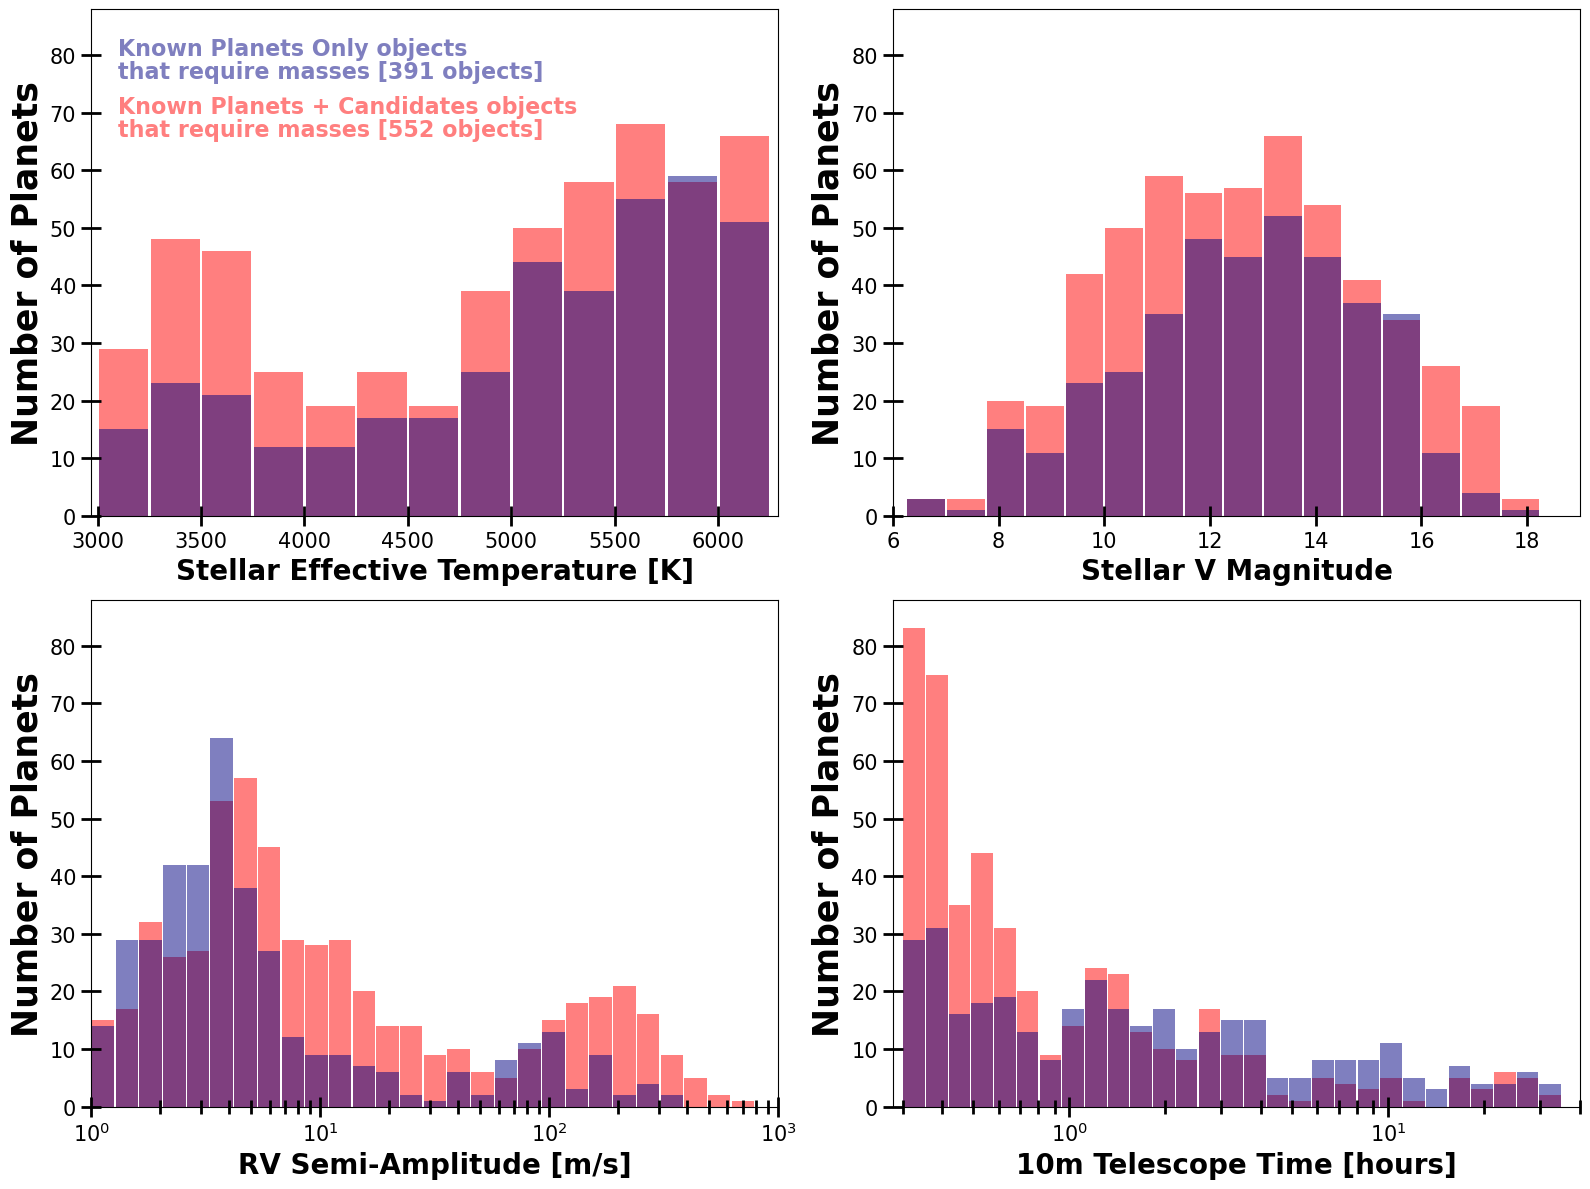

In [81]:
fig = plt.figure(1,[16,12])

RV_ObsData_All = RV_FollowUp_All[RV_FollowUp_All['Final_TelTime']>0]
RV_ObsData_KP = RV_FollowUp_KP[RV_FollowUp_KP['Final_TelTime']>0]

ymax=88.

ax1 = fig.add_subplot(2,2,1)
n_bins1=[3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750]
ax1.hist(RV_ObsData_All['teff_*'], n_bins1, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax1.hist(RV_ObsData_KP['teff_*'], n_bins1, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax1.text(3100,80,'Known Planets Only objects',fontsize=16,fontweight='bold',color='navy',alpha=.5)
ax1.text(3100,76,'that require masses [391 objects]',fontsize=16,fontweight='bold',color='navy',alpha=.5)
ax1.text(3100,70,'Known Planets + Candidates objects',fontsize=16,fontweight='bold',color='red',alpha=.5)
ax1.text(3100,66,'that require masses [552 objects]',fontsize=16,fontweight='bold',color='red',alpha=.5)

ax1.set_xlim([2970,6290])
ax1.set_ylim([0,ymax])
ax1.set_xlabel('Stellar Effective Temperature [K]',fontsize=20,fontweight='bold')
ax1.set_ylabel('Number of Planets',fontsize=25,fontweight='bold')
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


ax2 = fig.add_subplot(2,2,2)
n_bins2=np.arange(5.5,19.5,step=.75)
ax2.hist(RV_ObsData_All['vmag'], n_bins2, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax2.hist(RV_ObsData_KP['vmag'], n_bins2, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax2.set_xlim([6,19])
ax2.set_ylim([0,ymax])
ax2.set_xlabel('Stellar V Magnitude',fontsize=20,fontweight='bold')
ax2.set_ylabel('Number of Planets',fontsize=25,fontweight='bold')
ax2.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


ax3 = fig.add_subplot(2,2,3)
bins3=np.logspace(np.log10(1),np.log10(1000.), 30)
ax3.hist(RV_ObsData_All['predicted_K_p'], bins=bins3, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax3.hist(RV_ObsData_KP['predicted_K_p'], bins=bins3, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax3.set_xlim([1,1000.])
ax3.set_xscale('log')
ax3.set_ylim([0,ymax])
ax3.set_xlabel('RV Semi-Amplitude [m/s]',fontsize=20,fontweight='bold')
ax3.set_ylabel('Number of Planets',fontsize=25,fontweight='bold')
ax3.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax3.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)

ax4 = fig.add_subplot(2,2,4)
bins4=np.logspace(np.log10(.3),np.log10(35.), 30)
ax4.hist(RV_ObsData_All['Final_TelTime']*10., bins=bins4, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax4.hist(RV_ObsData_KP['Final_TelTime']*10., bins=bins4, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax4.set_xlim([.28,40.])
ax4.set_xscale('log')
ax4.set_ylim([0,ymax])
ax4.set_xlabel('10m Telescope Time [hours]',fontsize=20,fontweight='bold')
ax4.set_ylabel('Number of Planets',fontsize=25,fontweight='bold')
ax4.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax4.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


#plt.show()
plt.tight_layout()
plt.savefig('PaperFigures_Resubmission/Figure12.pdf') 

## Set up the sorted arrays for each of the RV prioritizations

In [82]:
###########################################
##   Figure of Merit RV Prioritization   ##
###########################################

Targets_Spread_All_FoMSort_Plot = RV_FollowUp_All[['name','mass_sigma_needed','FoM_trans','Final_TelTime','Facility','radius_p','teq_p']].copy()
Targets_Spread_All_FoMSort_Plot.drop(Targets_Spread_All_FoMSort_Plot[Targets_Spread_All_FoMSort_Plot['mass_sigma_needed'] == 0].index, inplace = True)
Targets_Spread_All_FoMSort_Plot.sort_values('FoM_trans',ascending=False,inplace=True)
Targets_Spread_All_FoMSort_Plot.reset_index(drop=True,inplace=True)
print('Done with FoM Sort')

#############################################
##   Maximizing N_planets Prioritization   ##
#############################################

Targets_Spread_All_EffSort_Plot = RV_FollowUp_All[['name','mass_sigma_needed','FoM_trans','Final_TelTime','Facility','radius_p','teq_p']].copy()
Targets_Spread_All_EffSort_Plot.drop(Targets_Spread_All_EffSort_Plot[Targets_Spread_All_EffSort_Plot['mass_sigma_needed'] == 0].index, inplace = True)
Targets_Spread_All_EffSort_Plot.sort_values('Final_TelTime',ascending=True,na_position='first',inplace=True)
Targets_Spread_All_EffSort_Plot.reset_index(drop=True,inplace=True)
print('Done with Efficiency Sort')

######################################################
##   Much longer section for optimizing number of   ##
##    RV planets across the T_eq vs Radius grid     ##
######################################################

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
RVs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

full_list = RV_FollowUp_All[['name','mass_sigma_needed','FoM_trans','Final_TelTime','Facility','radius_p','teq_p']].copy()
print(len(full_list))
full_list.drop(full_list[full_list['mass_sigma_needed'] == 0].index, inplace = True)
full_list.reset_index(inplace=True,drop=True)
print(len(full_list))
total_targets = len(full_list)
print('Total number of planets that need RV masses: ',total_targets)

iteration=0
while len(planets) < total_targets:
    planet_to_append=''
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= full_list['radius_p'].values)*(full_list['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= full_list['teq_p'].values) * (full_list['teq_p'].values < Teqvals[j + 1]))
            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue
            # If running first time, grab planet with smallest RV time and stash into box
            if counter[i,j] == 0:
                subset = full_list[idx]
                subset.sort_values('Final_TelTime',ascending=True,inplace=True)
                subset.reset_index(drop=True,inplace=True)
                #minRVTime = subset['Final_TelTime'][0]
                planet_to_append=subset['name'][0]
                planets.append(planet_to_append)
                RVs[i,j] = subset['Final_TelTime'][0]
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                nextoneidx, = np.where(full_list['Final_TelTime'][idx] >= RVs[i,j])
                
                if len(nextoneidx)==0:
                    # If no more, then continue
                    continue
                else:
                    # Grab the next largest one
                    minRVTime = min(np.array(full_list['Final_TelTime'][idx])[nextoneidx])
                    RVs[i, j] = minRVTime
                    planet_to_append_temp = full_list['name'][idx][full_list['Final_TelTime'][idx] == minRVTime]
                    planet_to_append = planet_to_append_temp.values[0]
                    planets.append(planet_to_append)
                    counter[i, j] = counter[i,j] + 1

            #print('planet to append: ',planet_to_append)
            if planet_to_append != '':
                full_list.drop(full_list[full_list['name'] == planet_to_append].index, inplace = True)

    iteration+=1

Targets_Spread_All_BinSort_Plot = RV_FollowUp_All[['name','mass_sigma_needed','FoM_trans','Final_TelTime','Facility','radius_p','teq_p']].copy()
Targets_Spread_All_BinSort_Plot.drop(Targets_Spread_All_BinSort_Plot[Targets_Spread_All_BinSort_Plot['mass_sigma_needed'] == 0].index, inplace = True)
Targets_Spread_All_BinSort_Plot.set_index('name',inplace=True)
df_planets = pd.DataFrame(planets,columns=['name'])
df_planets.set_index('name',inplace=True)
Targets_Spread_All_BinSort_Plot = Targets_Spread_All_BinSort_Plot.reindex(df_planets.index)

Done with FoM Sort
Done with Efficiency Sort
794
552
Total number of planets that need RV masses:  552


/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/1066878945.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values('Final_TelTime',ascending=True,inplace=True)


## Determine by hand how many planets fit into 25 nights of observations in each prioritization scheme

In [118]:
## Version that's actually for 25 nights
print(np.sum(Targets_Spread_All_FoMSort_Plot['Final_TelTime'][0:276]))
nplanets_FoMSort_25nights = 276

print(np.sum(Targets_Spread_All_EffSort_Plot['Final_TelTime'][0:452]))
nplanets_EffSort_25nights = 452

print(np.sum(Targets_Spread_All_BinSort_Plot['Final_TelTime'][0:209]))
nplanets_BinSort_25nights = 209

#Old Version for 50 nights
#print(np.sum(Targets_Spread_All_FoMSort_Plot['Final_TelTime'][0:435]))
#nplanets_FoMSort_50nights = 435

#print(np.sum(Targets_Spread_All_EffSort_Plot['Final_TelTime'][0:497]))
#nplanets_EffSort_50nights = 497

#print(np.sum(Targets_Spread_All_BinSort_Plot['Final_TelTime'][0:349]))
#nplanets_BinSort_50nights = 349

23.102444444444444
24.975111111111108
22.633555555555557


## Figure Showing RV Survey Approach Comparisons

In [124]:
Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]


Targets_Spread_All_FoMSort_Plot_25nights=Targets_Spread_All_FoMSort_Plot[0:nplanets_FoMSort_25nights]  #25 nights
counter_FoM_25 = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        idx = ((Rpvals[i] <= Targets_Spread_All_FoMSort_Plot_25nights['radius_p'].values)*(Targets_Spread_All_FoMSort_Plot_25nights['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Targets_Spread_All_FoMSort_Plot_25nights['teq_p'].values) * (Targets_Spread_All_FoMSort_Plot_25nights['teq_p'].values < Teqvals[j + 1]))
        counter_FoM_25[i,j]=np.sum(idx)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Targets_Spread_All_EffSort_Plot_25nights=Targets_Spread_All_EffSort_Plot[0:nplanets_EffSort_25nights] #25 nights
counter_Eff_25 = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        idx = ((Rpvals[i] <= Targets_Spread_All_EffSort_Plot_25nights['radius_p'].values)*(Targets_Spread_All_EffSort_Plot_25nights['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Targets_Spread_All_EffSort_Plot_25nights['teq_p'].values) * (Targets_Spread_All_EffSort_Plot_25nights['teq_p'].values < Teqvals[j + 1]))
        counter_Eff_25[i,j]=np.sum(idx)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Targets_Spread_All_BinSort_Plot_25nights=Targets_Spread_All_BinSort_Plot[0:nplanets_BinSort_25nights] #25 nights
counter_Bin_25 = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        idx = ((Rpvals[i] <= Targets_Spread_All_BinSort_Plot_25nights['radius_p'].values)*(Targets_Spread_All_BinSort_Plot_25nights['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Targets_Spread_All_BinSort_Plot_25nights['teq_p'].values) * (Targets_Spread_All_BinSort_Plot_25nights['teq_p'].values < Teqvals[j + 1]))
        counter_Bin_25[i,j]=np.sum(idx)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#CumulNights_Index=np.zeros(len(Targets_Spread_All_FoMSort_Plot_50nights))
#CumulNights_FoMSort=np.zeros(len(Targets_Spread_All_FoMSort_Plot_50nights))
#CumulNights_EffSort=np.zeros(len(Targets_Spread_All_EffSort_Plot_50nights))
#CumulNights_BinSort=np.zeros(len(Targets_Spread_All_EffSort_Plot_50nights))

CumulNights_Index=np.zeros(total_targets)
CumulNights_FoMSort=np.zeros(total_targets)
CumulNights_EffSort=np.zeros(total_targets)
CumulNights_BinSort=np.zeros(total_targets)

total_targets

for i in range(0,len(CumulNights_FoMSort)):
    CumulNights_EffSort[i]=np.nansum(Targets_Spread_All_EffSort_Plot['Final_TelTime'][0:i+1])
    CumulNights_FoMSort[i]=np.nansum(Targets_Spread_All_FoMSort_Plot['Final_TelTime'][0:i+1])
    CumulNights_BinSort[i]=np.nansum(Targets_Spread_All_BinSort_Plot['Final_TelTime'][0:i+1])
    CumulNights_Index[i]=i

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig = plt.figure(1,[10,8])

########################################
#       ax1 -- Progression Plot
########################################

ax1 = fig.add_subplot(2,2,1)
ax1.plot(CumulNights_Index, CumulNights_EffSort, linestyle='-',linewidth=2,color='magenta')
ax1.plot(CumulNights_Index, CumulNights_FoMSort, linestyle='-',linewidth=2,color='green')
ax1.plot(CumulNights_Index, CumulNights_BinSort, linestyle='-',linewidth=2,color='gold')
ax1.text(10,95,'After 25 nights of',fontsize=12,fontweight='bold')
ax1.text(10,89,'10m telescope time:',fontsize=12,fontweight='bold')
ax1.text(10,80,'FoM Sort: '+str(int(nplanets_FoMSort_25nights))+' Planets',fontsize=12,fontweight='bold',color='green')
ax1.text(10,72,'Eff Sort: '+str(int(nplanets_EffSort_25nights))+' Planets',fontsize=12,fontweight='bold',color='magenta')
ax1.text(10,64,'Spread Sort: '+str(int(nplanets_BinSort_25nights))+' Planets',fontsize=12,fontweight='bold',color='goldenrod')
ax1.text(10,64,'Spread Sort: '+str(int(nplanets_BinSort_25nights))+' Planets',fontsize=12,fontweight='bold',color='gold',alpha=.5)
ax1.hlines(25,150,500,linestyle='--',color='black',linewidth=2)  #Horizontal line at 50 nights
#ax1.text(140,25,'25 nights',fontsize=12,fontweight='bold',color='black',horizontalalignment='right',verticalalignment='center')

ax1.set_xlabel('Number of Planets',fontsize=15,fontweight='bold')
ax1.set_ylabel('10m Telescope Nights',fontsize=15,fontweight='bold')
ax1.set_yticks([0,25,50,75,100])
ax1.set_xlim([-10,570])
ax1.set_ylim([-10,108])
ax1.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)


########################################
#          ax2 -- FoM Spread
########################################

#cmap_gr = plt.cm.brg_r  # define the colormap
cmap_gr = plt.cm.Greens  # define the colormap
cmaplist_gr = [cmap_gr(i) for i in range(0,255,2)]
cmap_gr = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist_gr, cmap_gr.N)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(counter_FoM_25,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap_gr, vmin=0, vmax=25,norm='linear')
ax2.set_xticklabels(Teqvals)
ax2.set_yticklabels(Rpvals)
ax2.grid(which='major', color='k', linestyle='-', linewidth=1)
ax2.set_xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
ax2.set_ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
ax2.set_title("FoM Survey after 25 Nights",fontsize=15,fontweight='bold',color='green')

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = ax2.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter_FoM_25[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
ax2.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)


########################################
#          ax3 -- Efficient Spread
########################################

cmap_pink = plt.cm.PiYG_r #cool_r  # define the colormap
cmaplist_pink = [cmap_pink(i) for i in range(125,255)]
cmap_pink = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist_pink, cmap_pink.N)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(counter_Eff_25,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap_pink, vmin=0, vmax=25,norm='linear')
ax3.set_xticklabels(Teqvals)
ax3.set_yticklabels(Rpvals)
ax3.grid(which='major', color='k', linestyle='-', linewidth=1)
ax3.set_xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
ax3.set_ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = ax3.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter_Eff_25[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
ax3.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax3.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)
ax3.set_title("Eff Survey after 25 Nights",fontsize=15,fontweight='bold',color='magenta')

########################################
#          ax4 -- Even Spread
########################################

cmap_yl = plt.cm.hot_r  # define the colormap
cmaplist_yl = [cmap_yl(i) for i in range(0,80)]
cmap_yl = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist_yl, cmap_yl.N)

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(counter_Bin_25,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap_yl, vmin=0, vmax=25,norm='linear')
ax4.set_xticklabels(Teqvals)
ax4.set_yticklabels(Rpvals)
ax4.grid(which='major', color='k', linestyle='-', linewidth=1)
ax4.set_xlabel("Equilibrium Temperature [K]",fontsize=15,fontweight='bold')
ax4.set_ylabel("Planet Radius [R$_{\oplus}$]",fontsize=15,fontweight='bold')
for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = ax4.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter_Bin_25[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
ax4.tick_params(axis='both',which='major',labelsize=14,direction='inout',length=15,width=2)
ax4.tick_params(axis='both',which='minor',labelsize=14,direction='inout',length=10,width=2)
ax4.set_title("Spread Survey after 25 Nights",fontsize=15,fontweight='bold',color='goldenrod')

plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
plt.setp(ax4.spines.values(), linewidth=3)

plt.tight_layout()
#plt.show() 
plt.savefig('PaperFigures_Resubmission/Figure13.pdf',format='pdf',bbox_inches=None)
plt.close()

/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3859645875.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3859645875.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(Rpvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3859645875.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(Teqvals)
/var/folders/tm/3619648j46s04dxhxrh79nhm0000gq/T/ipykernel_87905/3859645875.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(Rpvals)
/var/folders/tm/3619648j46s04dxh

In [145]:
print(np.average(RV_ObsData_All['vmag'][(RV_ObsData_All['radius_p']>0.3) & (RV_ObsData_All['radius_p']<=1.5) & (RV_ObsData_All['teq_p']>2250) & (RV_ObsData_All['teq_p']<=3000)]))
print(np.average(RV_ObsData_All['vmag'][(RV_ObsData_All['radius_p']>0.3) & (RV_ObsData_All['radius_p']<=1.5) & (RV_ObsData_All['teq_p']>1750) & (RV_ObsData_All['teq_p']<=2250)]))

13.899666666666667
12.071987499999999


# Older / Unused Figures

## Testing Eclipse Deptg Calculations

In [ ]:
#Basic idea: imic the selection process across the 30 grid squares, taking the top 5 planets for emission spectroscopy in each, 
#but then impose a criteria of ‘Eclipse depth must be deeper than 20 ppm’ based on the Ariel sensitivity we discuss in the paper. 
#Use Rob's function to calculate eclipse depths  to produce a depth for each planet that makes it into the initial emission grid, 
#and then boot those with depths that are too small.

#Testing eclipse depth estimates against results of Knutson 2012 : https://ui.adsabs.harvard.edu/abs/2012ApJ...754...22K/abstract

def planck(temp,wave):
    h = 6.626070040E-34
    c = 299792458.
    kB = 1.38064852E-23
    return (((2.*h*c*c)/wave**5.)/(np.exp((h*c)/(wave*kB*temp))-1.))

def eclipsedepth(temp,startemp,wave,RpRs):
    FpFs = planck(temp,wave) / planck(startemp,wave)
    transit_depth = RpRs**2.
    eclipse_depth = FpFs * transit_depth
    return eclipse_depth

#wave = 1.65e-6  #center of H-band at 1.65 microns

hd189733_teff = 5100.

## For Spitzer 3.6 micron band
wave = 3.6e-6
hd189733b_teq = 1328.
rprstar = 0.15511

## For Spitzer 4.5 micron band
wave = 4.5e-6
hd189733b_teq = 1192.
rprstar = 0.15580

hd189733_ecldepth = eclipsedepth(hd189733b_teq,hd189733_teff,wave,rprstar)

print('Wavelength: ',wave)
print('eclipse depth %: ',hd189733_ecldepth*100.)

## Histogram of host star temperatures

In [ ]:
fig = plt.figure(1,[10,6])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

n_bins=[3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750]

n1, bins1, patches1 = ax1.hist(RV_ObsData_KP['teff_*'][RV_ObsData_KP['Final_TelTime']>0], n_bins, color='grey', histtype='bar', stacked=False, rwidth=.95)
bin_centers1 = 0.5 * (bins1[:-1] + bins1[1:])
col1 = bin_centers1 - min(bin_centers1)
col1 /= max(col1)
for c1, p1 in zip(col1, patches1):
    plt.setp(p1, 'facecolor', cmap_mod(c1))
#ax1.text(3100,62,'Known Planets Only',fontsize=14,color='black',fontweight='bold')
ax1.set_xlim([2970,6290])
ax1.set_ylim([0,70])
ax1.set_xlabel('Stellar Effective Temperature [K]',fontsize=20,fontweight='bold')
#ax1.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=3)


n2, bins2, patches2 = ax2.hist(RV_ObsData_All['teff_*'][RV_ObsData_All['Final_TelTime']>0], n_bins, color='grey', histtype='bar', stacked=False, rwidth=.95)
bin_centers2 = 0.5 * (bins2[:-1] + bins2[1:])
col2 = bin_centers2 - min(bin_centers2)
col2 /= max(col2)
for c2, p2 in zip(col2, patches2):
    plt.setp(p2, 'facecolor', cmap_mod(c2))
#ax2.text(3100,62,'Known Planets + Candidates',fontsize=14,color='black',fontweight='bold')
ax2.set_xlim([2970,6290])
ax2.set_ylim([0,70])
ax2.set_xlabel('Stellar Effective Temperature [K]',fontsize=20,fontweight='bold')
#ax2.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax2.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)
plt.setp(ax2.spines.values(), linewidth=3)

plt.show()
#plt.savefig('AllTOIs_Histogram.pdf') 

In [ ]:
fig = plt.figure(1,[16,12])

RV_ObsData_All = RV_FollowUp_All[RV_FollowUp_All['Final_TelTime']>0]
RV_ObsData_KP = RV_FollowUp_KP[RV_FollowUp_KP['Final_TelTime']>0]

ymax=85.

ax1 = fig.add_subplot(2,2,1)
n_bins1=[3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750]
ax1.hist(RV_ObsData_All['teff_*'], n_bins1, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax1.hist(RV_ObsData_KP['teff_*'], n_bins1, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax1.text(3100,80,'KP Only Planets that ',fontsize=15,fontweight='bold',color='navy',alpha=.5)
ax1.text(3100,76,'require masses [397 objects]',fontsize=15,fontweight='bold',color='navy',alpha=.5)
ax1.text(3100,68,'KP + Candidate Planets that ',fontsize=16,fontweight='bold',color='red',alpha=.5)
ax1.text(3100,64,'require masses [533 objects]',fontsize=16,fontweight='bold',color='red',alpha=.5)

ax1.set_xlim([2970,6290])
ax1.set_ylim([0,ymax])
ax1.set_xlabel('Stellar Effective Temperature [K]',fontsize=20,fontweight='bold')
ax1.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


ax2 = fig.add_subplot(2,2,2)
n_bins2=np.arange(5.5,19.5,step=.75)
ax2.hist(RV_ObsData_All['vmag'], n_bins2, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax2.hist(RV_ObsData_KP['vmag'], n_bins2, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax2.set_xlim([6,19])
ax2.set_ylim([0,ymax])
ax2.set_xlabel('Stellar V Magnitude',fontsize=20,fontweight='bold')
ax2.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax2.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax2.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


ax3 = fig.add_subplot(2,2,3)
bins3=np.logspace(np.log10(1),np.log10(1000.), 30)
ax3.hist(RV_ObsData_All['predicted_K_p'], bins=bins3, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax3.hist(RV_ObsData_KP['predicted_K_p'], bins=bins3, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax3.set_xlim([1,1000.])
ax3.set_xscale('log')
ax3.set_ylim([0,ymax])
ax3.set_xlabel('RV Semi-Amplitude [m/s]',fontsize=20,fontweight='bold')
ax3.set_ylabel('Number of Planets',fontsize=25,fontweight='bold')
ax3.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax3.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)

ax4 = fig.add_subplot(2,2,4)
bins4=np.logspace(np.log10(.3),np.log10(35.), 30)
ax4.hist(RV_ObsData_All['Final_TelTime']*10., bins=bins4, color='red', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax4.hist(RV_ObsData_KP['Final_TelTime']*10., bins=bins4, color='navy', histtype='bar', stacked=False, rwidth=.95,alpha=.5)
ax4.set_xlim([.28,40.])
ax4.set_xscale('log')
ax4.set_ylim([0,ymax])
ax4.set_xlabel('10m Telescope Time [hours]',fontsize=20,fontweight='bold')
ax4.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax4.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax4.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)


plt.show()
#plt.savefig('AllTOIs_Histogram.pdf') 

## Summary Figure of RV Targets

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
divider = make_axes_locatable(ax)
yhax = divider.append_axes("right", size=1, pad=0.1, sharey=ax1)

plot=ax.scatter(RV_FollowUp_All['predicted_K_p'],RV_FollowUp_All['Final_TelTime']*10.,s=250,c=RV_FollowUp_All['teff_*'], cmap = cmap_mod,edgecolor='black',vmin=2800., vmax=6500,alpha=.5)
ax.text(900,25,'Known Planets + Candidates',fontsize=14,color='black',fontweight='bold',horizontalalignment='right')
ax.set_xlabel('RV Semi-Amplitude [m s$^{-1}$]',fontsize=20,fontweight='bold')
ax.set_ylabel('10m Telescope Time [hours]',fontsize=20,fontweight='bold')
ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=7,width=1)
ax.tick_params(axis='both',which='major',labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((.9,1000))
ax.set_ylim((.25,35))

#RV Semi-amp Histogram
yhax.hist(RV_FollowUp_All['Final_TelTime']*10.,bins=np.logspace(np.log10(0.25),np.log10(35.), 50),align='mid',color='dimgrey',histtype='bar', ec='grey',orientation="horizontal")
yhax.text(90,30,'10m Telescope Time [Hours]',fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.set_xticks([25,50,75,100])
yhax.tick_params(axis='both',which='major',labelsize=8)
yhax.set_xlim(0,114)
yhax.set_ylim(.25,35)
yhax.set_yscale('log')
plt.setp(yhax.get_yticklabels(), visible=False)
plt.setp(ax1.spines.values(), linewidth=3)

plt.tight_layout()
plt.show()
#plt.savefig('ScatterPlotExample.pdf') 

In [ ]:
RV_FollowUp_All

RV_ObsData_All = RV_FollowUp_All[RV_FollowUp_All['Final_TelTime']>0]

#Make plot
fig, ax = plt.subplots(figsize=(8,6))
divider = make_axes_locatable(ax)
yhax = divider.append_axes("right", size=1, pad=0.1, sharey=ax1)

plot=ax.scatter(RV_ObsData_All['vmag'],RV_ObsData_All['predicted_K_p'],s=250,c=RV_ObsData_All['teff_*'], cmap = cmap_mod,edgecolor='black',vmin=2800., vmax=6500,alpha=.5)
ax.text(6.5,700,'Known Planets + Candidates',fontsize=14,color='black',fontweight='bold')
ax.set_ylabel('RV Semi-Amplitude [m s$^{-1}$]',fontsize=20,fontweight='bold')
ax.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=7,width=1)
ax.tick_params(axis='both',which='major',labelsize=20)
ax.set_yscale('log')
ax.set_ylim((1,1000))
ax.set_xlim((6,19))

#RV Semi-amp Histogram
yhax.hist(RV_ObsData_All['predicted_K_p'],bins=np.logspace(np.log10(1.),np.log10(1000.), 50),align='mid',color='dimgrey',histtype='bar', ec='grey',orientation="horizontal")
yhax.text(35,900,'RV Semi-Amplitude [m s$^{-1}$]',fontsize=10,fontweight='bold',rotation=270,verticalalignment='top')
yhax.set_xticks([10,20,30,40])
yhax.tick_params(axis='both',which='major',labelsize=8)
yhax.set_yscale('log')
yhax.set_xlim(1,45)
yhax.set_ylim(1,1000)
plt.setp(yhax.get_yticklabels(), visible=False)

plt.setp(ax1.spines.values(), linewidth=3)

plt.tight_layout()
plt.show()
#plt.savefig('ScatterPlotExample.pdf') 

In [ ]:
fig = plt.figure(1,[8,6])
ax1 = fig.add_subplot(1,1,1)

n_bins=[3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750]

ax1.hist([RV_ObsData_All['teff_*'][RV_ObsData_All['Final_TelTime']>0],RV_ObsData_KP['teff_*'][RV_ObsData_KP['Final_TelTime']>0]], n_bins, color=['red','navy'], histtype='bar', density=True, stacked=False, rwidth=.95,alpha=.5)

ax1.text(3100,0.0006,'Normalized KP + Candidate Planets that require masses',fontsize=12,fontweight='bold',color='red',alpha=.5)
ax1.text(3100,0.00055,'Normalized KP Only Planets that require masses',fontsize=12,fontweight='bold',color='navy',alpha=.5)

ax1.set_xlim([2970,6290])
#ax1.set_ylim([0,70])
ax1.set_xlabel('Stellar Effective Temperature [K]',fontsize=20,fontweight='bold')
ax1.set_ylabel('Number of Host Stars',fontsize=25,fontweight='bold')
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=15,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=3)


plt.show()
#plt.savefig('AllTOIs_Histogram.pdf') 

In [ ]:
import dill                            #pip install dill --user
filename = 'RepPlanets_Global.pkl'
dill.dump_session(filename)